# 🛰️ Exploratory Data Analysis - Multispectral (MS) Images

<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 20px; border-radius: 10px; color: white;">

## 📋 Mục lục
1. **Cấu hình & Import Libraries**
2. **Tổng quan Dataset**
3. **Phân tích Metadata & Cấu trúc ảnh**
4. **Phân tích Phân bố theo Class**
5. **Phân tích Giá trị Pixel & Thống kê**
6. **Phân tích Tương quan giữa các Bands**
7. **Trực quan hóa mẫu ảnh**
8. **Phát hiện Anomalies & Quality Report**
9. **Tổng kết & Recommendations**

</div>

---

**📅 Ngày phân tích:** Tháng 2, 2026  
**🎯 Mục tiêu:** Phân tích toàn diện dữ liệu ảnh đa phổ (Multispectral) cho bài toán phân loại bệnh cây trồng

In [20]:
# ============================================================================
# 📦 SECTION 1: IMPORT LIBRARIES & CONFIGURATION
# ============================================================================

import os
import glob
import warnings
import pandas as pd
import numpy as np
import tifffile as tiff
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from tqdm import tqdm
from scipy import stats
from collections import Counter

# Tắt warnings không cần thiết
warnings.filterwarnings('ignore')

# ═══════════════════════════════════════════════════════════════════════════
# 🎨 CẤU HÌNH STYLE CHUYÊN NGHIỆP
# ═══════════════════════════════════════════════════════════════════════════

# Custom color palette
COLORS = {
    'primary': '#2E86AB',      # Xanh dương chính
    'secondary': '#A23B72',     # Hồng tím
    'accent': '#F18F01',        # Cam
    'success': '#C73E1D',       # Đỏ
    'background': '#F5F5F5',    # Xám nhạt
    'Health': '#2ECC71',        # Xanh lá - Healthy
    'Rust': '#E74C3C',          # Đỏ - Rust disease
    'Other': '#9B59B6',         # Tím - Other
    'Unknown': '#95A5A6'        # Xám - Unknown
}

# Matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (14, 8),
    'figure.dpi': 100,
    'font.size': 11,
    'font.family': 'sans-serif',
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.fancybox': True,
    'legend.shadow': True
})

# ═══════════════════════════════════════════════════════════════════════════
# 📁 ĐỊNH NGHĨA ĐƯỜNG DẪN DATASET
# ═══════════════════════════════════════════════════════════════════════════

BASE_DIR = r'D:\GitHub\AI-for-Agriculture-2026\dataset'
MS_TRAIN_DIR = os.path.join(BASE_DIR, 'train', 'MS')

# Định nghĩa bands cho ảnh MS
MS_BANDS = {
    0: 'Blue (450nm)',
    1: 'Green (560nm)', 
    2: 'Red (650nm)',
    3: 'Red Edge (730nm)',
    4: 'NIR (840nm)'
}

print("✅ Libraries imported successfully!")
print(f"📁 Train Directory: {MS_TRAIN_DIR}")
# print(f"📁 Validation Directory: {MS_VAL_DIR}")
print(f"🔬 MS Bands: {len(MS_BANDS)} channels")

✅ Libraries imported successfully!
📁 Train Directory: D:\GitHub\AI-for-Agriculture-2026\dataset\train\MS
🔬 MS Bands: 5 channels


---
## 📊 Section 2: Tổng quan Dataset & Thu thập Metadata

> Quét toàn bộ dataset để thu thập thông tin về cấu trúc, kích thước, và metadata của ảnh MS.

In [21]:
# ============================================================================
# 📊 SECTION 2: COMPREHENSIVE METADATA COLLECTION
# ============================================================================

def collect_ms_metadata(img_dir, split_name="train"):
    """
    Thu thập metadata chi tiết từ tất cả ảnh MS trong thư mục.
    
    Parameters:
    -----------
    img_dir : str - Đường dẫn đến thư mục ảnh
    split_name : str - Tên split (train/val)
    
    Returns:
    --------
    pd.DataFrame - DataFrame chứa toàn bộ metadata
    """
    paths = glob.glob(os.path.join(img_dir, "**/*.tif*"), recursive=True)
    rows = []
    
    print(f"🔍 Scanning {len(paths)} MS images in {split_name} set...")
    
    for p in tqdm(paths, desc=f"Processing {split_name}", ncols=80):
        filename = os.path.basename(p)
        
        # Extract class từ tên file
        if filename.startswith('Health'):
            label = 'Health'
        elif filename.startswith('Rust'):
            label = 'Rust'
        elif filename.startswith('Other'):
            label = 'Other'
        else:
            label = 'Unknown'
        
        try:
            with tiff.TiffFile(p) as tf:
                series = tf.series[0]
                shape = series.shape
                dtype = series.dtype
                
                # Xác định layout và dimensions
                if len(shape) == 3:
                    if shape[0] < shape[2]:
                        c, h, w = shape
                        layout = "CHW"
                    else:
                        h, w, c = shape
                        layout = "HWC"
                else:
                    h, w = shape[:2]
                    c = 1
                    layout = "2D"
                
                # File size
                file_size_mb = os.path.getsize(p) / (1024 * 1024)
                
                rows.append({
                    "File Name": filename,
                    "Path": p,
                    "Split": split_name,
                    "Class": label,
                    "Height": h,
                    "Width": w,
                    "Channels": c,
                    "Dtype": str(dtype),
                    "Layout": layout,
                    "Resolution": f"{h}x{w}",
                    "Total Pixels": h * w,
                    "File Size (MB)": round(file_size_mb, 3),
                    "Aspect Ratio": round(w / h, 2) if h > 0 else 0
                })
                
        except Exception as e:
            rows.append({
                "File Name": filename,
                "Path": p,
                "Split": split_name,
                "Class": label,
                "Error": str(e)
            })
    
    return pd.DataFrame(rows)

# Thu thập metadata từ train set
df_train = collect_ms_metadata(MS_TRAIN_DIR, "train")

# Chỉ sử dụng train set cho EDA
df_ms = df_train.copy()

print(f"\n✅ Total images collected: {len(df_ms)}")
print(f"   📂 Train: {len(df_train)} images")

🔍 Scanning 600 MS images in train set...


Processing train: 100%|██████████████████████| 600/600 [00:00<00:00, 881.48it/s]


✅ Total images collected: 600
   📂 Train: 600 images


---
## 📈 Section 3: Dataset Overview & Summary Statistics

> Hiển thị tổng quan về dataset với các bảng thống kê chuyên nghiệp.

In [22]:
# ============================================================================
# 📈 SECTION 3: DATASET OVERVIEW & SUMMARY STATISTICS
# ============================================================================

def create_summary_table(df):
    """Tạo bảng tổng kết dataset chuyên nghiệp"""
    
    # Tạo summary statistics
    summary_data = {
        'Metric': [
            '📊 Total Images',
            '📁 Train Images', 
            '📁 Validation Images',
            '🏷️ Number of Classes',
            '📐 Image Height',
            '📐 Image Width',
            '🔬 Number of Channels',
            '💾 Total Dataset Size',
            '📏 Average File Size'
        ],
        'Value': [
            f"{len(df):,}",
            f"{len(df[df['Split']=='train']):,}",
            f"{len(df[df['Split']=='val']):,}",
            f"{df['Class'].nunique()}",
            f"{df['Height'].mode().iloc[0] if not df.empty else 'N/A'}px",
            f"{df['Width'].mode().iloc[0] if not df.empty else 'N/A'}px",
            f"{df['Channels'].mode().iloc[0] if not df.empty else 'N/A'}",
            f"{df['File Size (MB)'].sum():.2f} MB",
            f"{df['File Size (MB)'].mean():.3f} MB"
        ]
    }
    
    return pd.DataFrame(summary_data)

# Hiển thị summary table
summary_df = create_summary_table(df_ms)
print("=" * 60)
print("📋 MULTISPECTRAL DATASET SUMMARY")
print("=" * 60)
display(summary_df.style.set_properties(**{
    'background-color': '#f8f9fa',
    'color': '#2c3e50',
    'border-color': '#dee2e6',
    'font-size': '12pt'
}).hide(axis='index'))

# Class distribution
print("\n" + "=" * 60)
print("🏷️ CLASS DISTRIBUTION")
print("=" * 60)

class_dist = df_ms.groupby(['Class', 'Split']).size().unstack(fill_value=0)
class_dist['Total'] = class_dist.sum(axis=1)
class_dist['Percentage'] = (class_dist['Total'] / class_dist['Total'].sum() * 100).round(2).astype(str) + '%'

display(class_dist.style.background_gradient(cmap='Blues', subset=['Total'])
        .set_properties(**{'font-size': '11pt'}))

📋 MULTISPECTRAL DATASET SUMMARY


Metric,Value
📊 Total Images,600
📁 Train Images,600
📁 Validation Images,0
🏷️ Number of Classes,3
📐 Image Height,64px
📐 Image Width,64px
🔬 Number of Channels,5
💾 Total Dataset Size,23.51 MB
📏 Average File Size,0.039 MB



🏷️ CLASS DISTRIBUTION


Split,train,Total,Percentage
Class,,,
Health,200,200,33.33%
Other,200,200,33.33%
Rust,200,200,33.33%


---
## 🎨 Section 4: Class Distribution Visualization

> Trực quan hóa phân bố classes với các biểu đồ chuyên nghiệp.

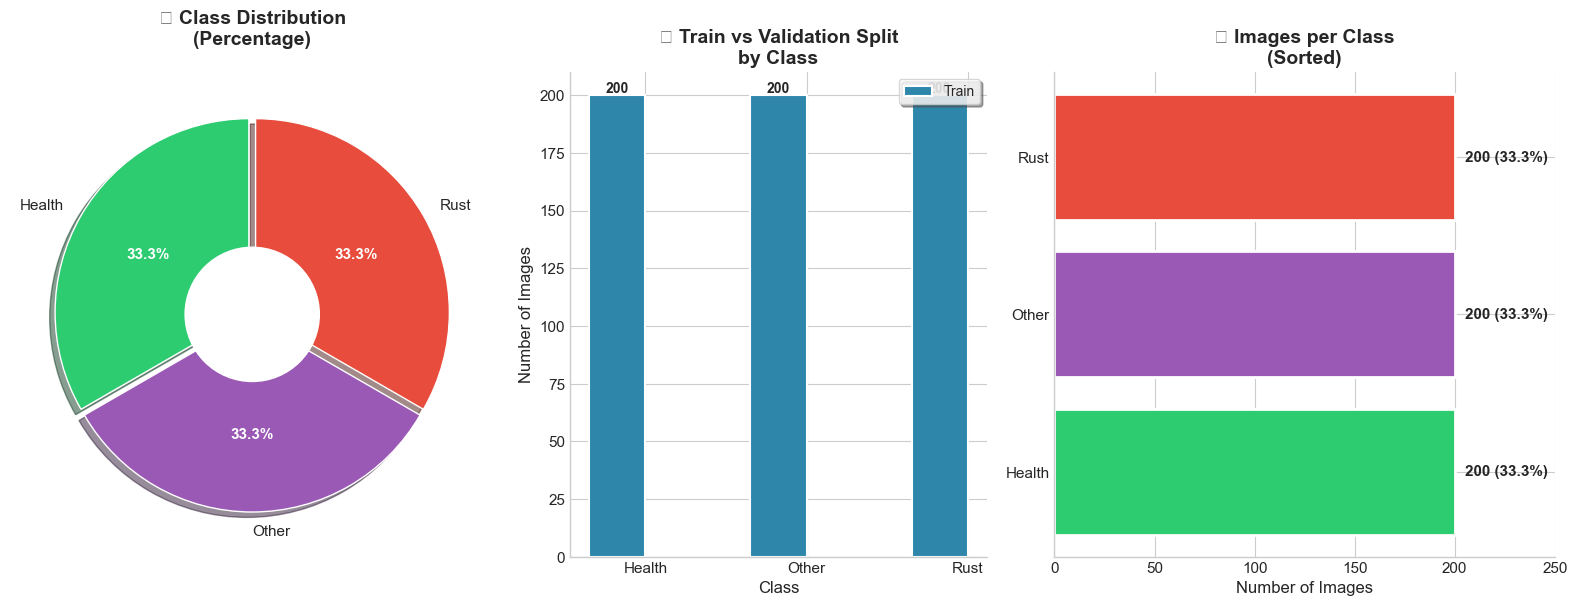

💾 Figure saved: ms_class_distribution.png


In [23]:
# ============================================================================
# 🎨 SECTION 4: CLASS DISTRIBUTION VISUALIZATION
# ============================================================================

fig = plt.figure(figsize=(16, 6))
gs = GridSpec(1, 3, width_ratios=[1.2, 1, 1.2])

# --- Chart 1: Pie Chart với Donut Style ---
ax1 = fig.add_subplot(gs[0])
class_counts = df_ms['Class'].value_counts()
n_classes = len(class_counts)

# Dynamic colors và explode theo số classes thực tế
class_colors_dynamic = [COLORS.get(cls, '#999999') for cls in class_counts.index]
explode_values = tuple([0.02] * n_classes)

wedges, texts, autotexts = ax1.pie(
    class_counts.values, 
    labels=class_counts.index,
    colors=class_colors_dynamic,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode_values,
    shadow=True,
    wedgeprops=dict(width=0.7, edgecolor='white')
)
ax1.set_title('🥧 Class Distribution\n(Percentage)', fontsize=14, fontweight='bold', pad=20)

# Style cho text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

# Thêm center circle để tạo donut
centre_circle = plt.Circle((0, 0), 0.35, fc='white')
ax1.add_patch(centre_circle)

# --- Chart 2: Bar Chart cho Train/Val Split ---
ax2 = fig.add_subplot(gs[1])
split_class = df_ms.groupby(['Class', 'Split']).size().unstack(fill_value=0)

x = np.arange(len(split_class.index))
width = 0.35

bars1 = ax2.bar(x - width/2, split_class['train'], width, label='Train', 
                color=COLORS['primary'], edgecolor='white', linewidth=1.5)
if 'val' in split_class.columns:
    bars2 = ax2.bar(x + width/2, split_class['val'], width, label='Validation',
                    color=COLORS['accent'], edgecolor='white', linewidth=1.5)

ax2.set_xlabel('Class')
ax2.set_ylabel('Number of Images')
ax2.set_title('📊 Train vs Validation Split\nby Class', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(split_class.index)
ax2.legend(loc='upper right')

# Thêm value labels
for bar in bars1:
    height = bar.get_height()
    ax2.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# --- Chart 3: Horizontal Bar với màu gradient ---
ax3 = fig.add_subplot(gs[2])
sorted_counts = class_counts.sort_values()

# Dynamic colors cho sorted classes
sorted_colors = [COLORS.get(cls, '#999999') for cls in sorted_counts.index]
bars = ax3.barh(range(len(sorted_counts)), sorted_counts.values, 
                color=sorted_colors, edgecolor='white', linewidth=2)

ax3.set_yticks(range(len(sorted_counts)))
ax3.set_yticklabels(sorted_counts.index)
ax3.set_xlabel('Number of Images')
ax3.set_title('📈 Images per Class\n(Sorted)', fontsize=14, fontweight='bold')

# Thêm value và percentage labels
total = sorted_counts.sum()
for i, (bar, val) in enumerate(zip(bars, sorted_counts.values)):
    pct = val / total * 100
    ax3.text(val + 5, bar.get_y() + bar.get_height()/2, 
             f'{val:,} ({pct:.1f}%)', va='center', fontweight='bold', fontsize=11)

ax3.set_xlim(0, sorted_counts.max() * 1.25)

plt.tight_layout()
plt.savefig('ms_class_distribution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("💾 Figure saved: ms_class_distribution.png")

---
## 📐 Section 5: Image Dimensions & Quality Analysis

> Phân tích kích thước ảnh, kiểm tra tính đồng nhất và phát hiện anomalies.

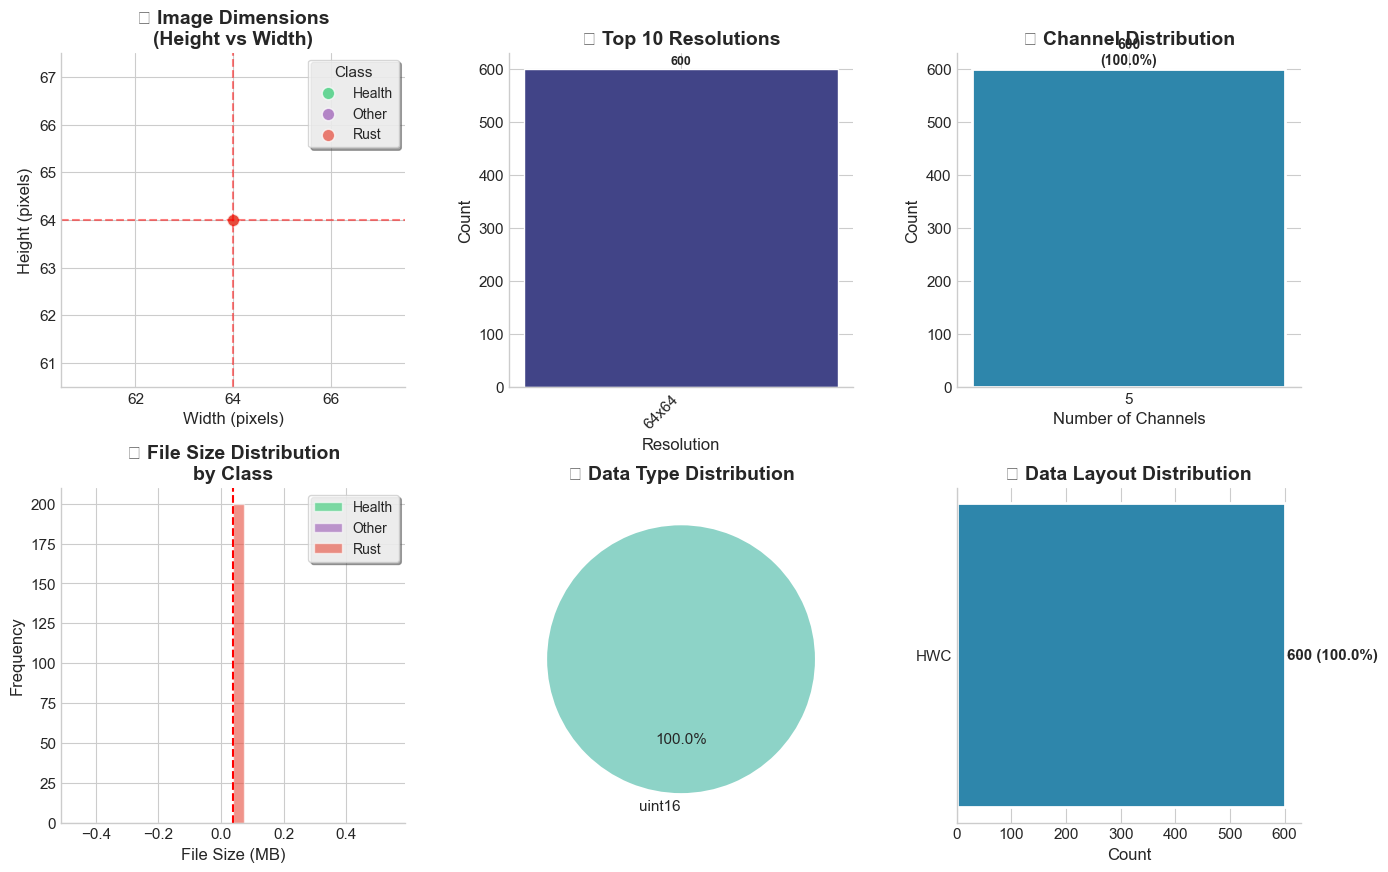

💾 Figure saved: ms_dimensions_analysis.png


In [24]:
# ============================================================================
# 📐 SECTION 5: IMAGE DIMENSIONS & QUALITY ANALYSIS
# ============================================================================

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, hspace=0.3, wspace=0.3)

# --- Chart 1: Scatter Plot H vs W ---
ax1 = fig.add_subplot(gs[0, 0])
for cls in df_ms['Class'].unique():
    subset = df_ms[df_ms['Class'] == cls]
    ax1.scatter(subset['Width'], subset['Height'], 
                c=COLORS[cls], label=cls, alpha=0.7, s=80, edgecolors='white')

ax1.set_xlabel('Width (pixels)')
ax1.set_ylabel('Height (pixels)')
ax1.set_title('📐 Image Dimensions\n(Height vs Width)', fontweight='bold')
ax1.legend(title='Class')
ax1.axhline(df_ms['Height'].median(), color='red', linestyle='--', alpha=0.5, label='Median H')
ax1.axvline(df_ms['Width'].median(), color='red', linestyle='--', alpha=0.5, label='Median W')

# --- Chart 2: Resolution Distribution ---
ax2 = fig.add_subplot(gs[0, 1])
resolution_counts = df_ms['Resolution'].value_counts().head(10)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(resolution_counts)))

bars = ax2.bar(range(len(resolution_counts)), resolution_counts.values, color=colors, edgecolor='white')
ax2.set_xticks(range(len(resolution_counts)))
ax2.set_xticklabels(resolution_counts.index, rotation=45, ha='right')
ax2.set_xlabel('Resolution')
ax2.set_ylabel('Count')
ax2.set_title('📊 Top 10 Resolutions', fontweight='bold')

for bar, val in zip(bars, resolution_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             str(val), ha='center', va='bottom', fontweight='bold', fontsize=9)

# --- Chart 3: Channel Distribution ---
ax3 = fig.add_subplot(gs[0, 2])
channel_counts = df_ms['Channels'].value_counts().sort_index()
bars = ax3.bar(channel_counts.index.astype(str), channel_counts.values, 
               color=COLORS['primary'], edgecolor='white', linewidth=2)
ax3.set_xlabel('Number of Channels')
ax3.set_ylabel('Count')
ax3.set_title('🔬 Channel Distribution', fontweight='bold')

for bar, val in zip(bars, channel_counts.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{val}\n({val/len(df_ms)*100:.1f}%)', ha='center', va='bottom', 
             fontweight='bold', fontsize=10)

# --- Chart 4: File Size Distribution ---
ax4 = fig.add_subplot(gs[1, 0])
for cls in df_ms['Class'].unique():
    subset = df_ms[df_ms['Class'] == cls]
    ax4.hist(subset['File Size (MB)'], bins=30, alpha=0.6, 
             label=cls, color=COLORS[cls], edgecolor='white')

ax4.set_xlabel('File Size (MB)')
ax4.set_ylabel('Frequency')
ax4.set_title('💾 File Size Distribution\nby Class', fontweight='bold')
ax4.legend()
ax4.axvline(df_ms['File Size (MB)'].mean(), color='red', linestyle='--', 
            label=f"Mean: {df_ms['File Size (MB)'].mean():.3f} MB")

# --- Chart 5: Data Type Distribution ---
ax5 = fig.add_subplot(gs[1, 1])
dtype_counts = df_ms['Dtype'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(dtype_counts)))

wedges, texts, autotexts = ax5.pie(
    dtype_counts.values, 
    labels=dtype_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    explode=[0.03] * len(dtype_counts)
)
ax5.set_title('🔢 Data Type Distribution', fontweight='bold')

# --- Chart 6: Layout Distribution ---
ax6 = fig.add_subplot(gs[1, 2])
layout_counts = df_ms['Layout'].value_counts()

bars = ax6.barh(layout_counts.index, layout_counts.values, 
                color=[COLORS['primary'], COLORS['secondary'], COLORS['accent']][:len(layout_counts)],
                edgecolor='white', linewidth=2)
ax6.set_xlabel('Count')
ax6.set_title('📋 Data Layout Distribution', fontweight='bold')

for bar, val in zip(bars, layout_counts.values):
    ax6.text(val + 5, bar.get_y() + bar.get_height()/2, 
             f'{val} ({val/len(df_ms)*100:.1f}%)', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('ms_dimensions_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("💾 Figure saved: ms_dimensions_analysis.png")

---
## 🚨 Section 5.1: Black Image Detection & Quality Check

> Kiểm tra các ảnh MS bị đen hoặc có chất lượng kém tương tự như đã thực hiện với RGB.

🔍 Checking quality of MS images...
📊 Total MS images to check: 600


Quality Check: 100%|█████████████████████████| 600/600 [00:01<00:00, 489.32it/s]


📊 OVERALL QUALITY REPORT - MULTISPECTRAL IMAGES
status
ok         577
flagged     23
Name: count, dtype: int64

🚨 DETAILED FLAGGED MS IMAGES REPORT (23 images)

📋 FULL LIST OF FLAGGED MS IMAGES:
----------------------------------------------------------------------------------------------------


,filename,class,status,reason,mean_value,std_value,black_ratio,white_ratio,W,H,C,dtype
23,Health_hyper_12.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,64,64,5,uint16
60,Health_hyper_153.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,64,64,5,uint16
75,Health_hyper_167.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,64,64,5,uint16
116,Health_hyper_23.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,64,64,5,uint16
119,Health_hyper_26.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,64,64,5,uint16
128,Health_hyper_34.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,64,64,5,uint16
132,Health_hyper_38.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,64,64,5,uint16
164,Health_hyper_67.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,64,64,5,uint16
174,Health_hyper_76.tif,Health,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,64,64,5,uint16
204,Other_hyper_102.tif,Other,flagged,"near_black,low_contrast",0.000000,0.000000,1.000000,0.000000,64,64,5,uint16



📊 FLAGGED IMAGES BY CLASS:
reason  near_black,low_contrast
class                          
Health                        9
Other                        14

💾 Quality report saved: ms_quality_report.csv

🖼️  VISUALIZING SAMPLE FLAGGED MS IMAGES


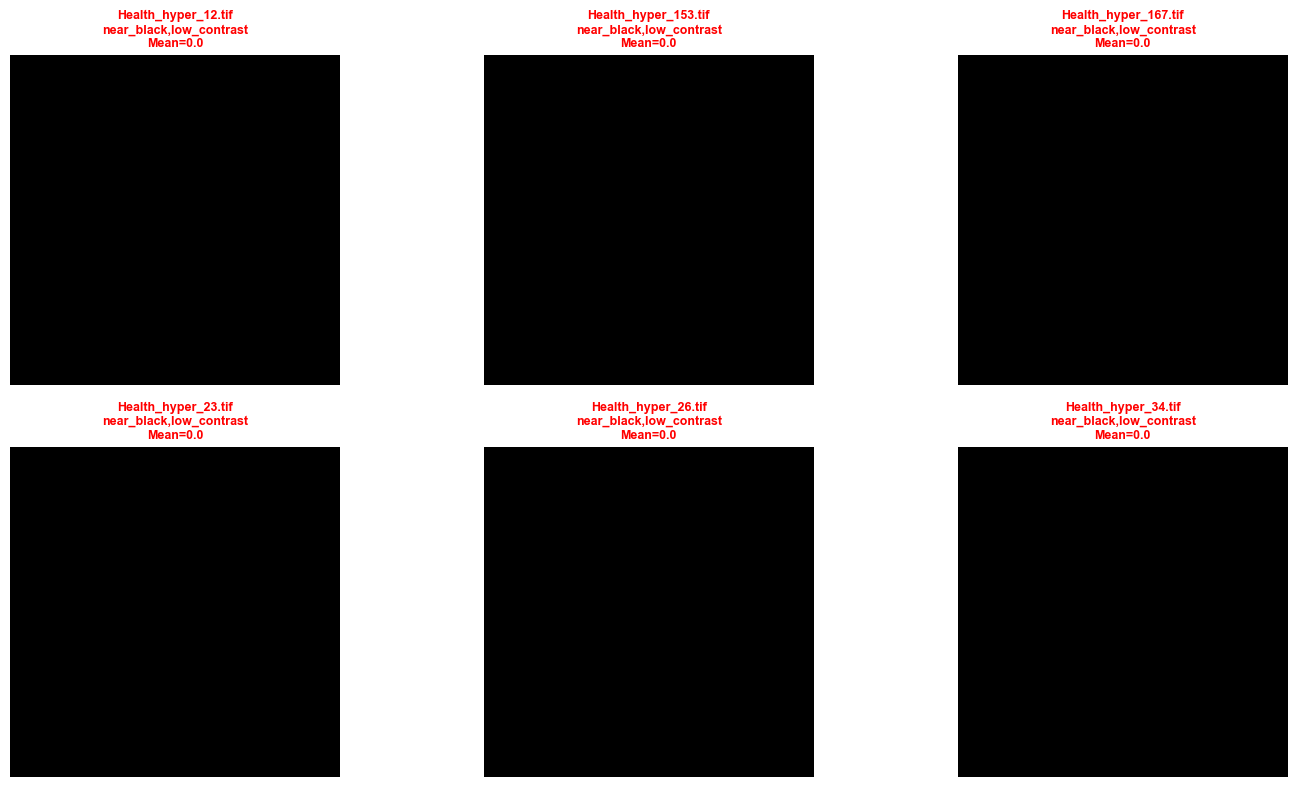

💾 Figure saved: ms_flagged_samples.png

✅ QUALITY CHECK COMPLETED


In [25]:
# ============================================================================
# 🚨 SECTION 5.1: BLACK IMAGE DETECTION & QUALITY CHECK
# ============================================================================

def quality_check_ms(path, 
                     black_mean_thr=50,       # Mean value thấp -> ảnh rất tối
                     black_ratio_thr=0.98,    # % pixel <= 50 quá cao -> gần như đen
                     low_std_thr=30,          # Std thấp -> gần như 1 màu (mất tương phản)
                     white_ratio_thr=0.98):   # % pixel >= 65000 quá cao -> quá sáng (với uint16)
    """
    Kiểm tra chất lượng ảnh MS (multi-spectral).
    
    Parameters:
    -----------
    path : str - Đường dẫn đến ảnh MS (.tif)
    black_mean_thr : float - Ngưỡng mean thấp để coi là ảnh tối
    black_ratio_thr : float - Ngưỡng tỷ lệ pixel đen
    low_std_thr : float - Ngưỡng std thấp (low contrast)
    white_ratio_thr : float - Ngưỡng tỷ lệ pixel trắng
    
    Returns:
    --------
    dict - Thông tin kiểm tra chất lượng
    """
    
    row = {"path": path, "status": "ok", "reason": ""}
    
    # 1) Check corrupt
    try:
        with tiff.TiffFile(path) as tf:
            # Verify có thể mở được
            series = tf.series[0]
            shape = series.shape
    except Exception as e:
        row["status"] = "corrupt"
        row["reason"] = f"verify_fail: {type(e).__name__}"
        return row
    
    # 2) Load và tính stats
    try:
        img = tiff.imread(path)
        
        # Xác định layout và chuyển về CHW
        if img.ndim == 3:
            if img.shape[0] > img.shape[2]:
                # HWC -> CHW
                img = np.transpose(img, (2, 0, 1))
            # Else already CHW
        else:
            row["status"] = "corrupt"
            row["reason"] = "unexpected_shape"
            return row
        
        c, h, w = img.shape
        row["W"], row["H"], row["C"] = w, h, c
        
        # Downsample để tính toán nhanh hơn (lấy mỗi 10 pixel)
        img_small = img[:, ::10, ::10].astype(np.float32)
        
        # Tính mean của tất cả bands
        mean_val = float(np.mean(img_small))
        std_val = float(np.std(img_small))
        
        # Với MS uint16, pixel value range [0, 65535]
        # Điều chỉnh threshold phù hợp với data type
        if img.dtype == np.uint16:
            black_pixel_thr = 50
            white_pixel_thr = 60000
        else:  # uint8 hoặc float
            black_pixel_thr = 10
            white_pixel_thr = 245
        
        black_ratio = float(np.mean(img_small <= black_pixel_thr))
        white_ratio = float(np.mean(img_small >= white_pixel_thr))
        
        row.update({
            "mean_value": mean_val,
            "std_value": std_val,
            "black_ratio": black_ratio,
            "white_ratio": white_ratio,
            "dtype": str(img.dtype)
        })
        
        # Flag detection
        flags = []
        if mean_val < black_mean_thr and black_ratio > black_ratio_thr:
            flags.append("near_black")
        if white_ratio > white_ratio_thr:
            flags.append("near_white")
        if std_val < low_std_thr:
            flags.append("low_contrast")
        
        if flags:
            row["status"] = "flagged"
            row["reason"] = ",".join(flags)
            
    except Exception as e:
        row["status"] = "corrupt"
        row["reason"] = f"load_fail: {type(e).__name__}"
        return row
    
    return row

# ====== CHẠY QUALITY CHECK ======
print("🔍 Checking quality of MS images...")

# Lấy tất cả file paths từ df_ms
ms_files = df_ms['Path'].tolist()

print(f"📊 Total MS images to check: {len(ms_files)}")

# Chạy quality check
quality_rows = []
for p in tqdm(ms_files, desc="Quality Check", ncols=80):
    result = quality_check_ms(p)
    quality_rows.append(result)

df_quality = pd.DataFrame(quality_rows)

# ========= THỐNG KÊ TỔNG QUAN =========
print("\n" + "=" * 100)
print("📊 OVERALL QUALITY REPORT - MULTISPECTRAL IMAGES")
print("=" * 100)
print(df_quality["status"].value_counts())

# ========= IN RA TẤT CẢ ẢNH BỊ FLAGGED =========
df_flagged = df_quality[df_quality["status"] != "ok"].copy()

if len(df_flagged) > 0:
    print("\n" + "=" * 100)
    print(f"🚨 DETAILED FLAGGED MS IMAGES REPORT ({len(df_flagged)} images)")
    print("=" * 100)
    
    # Thêm cột filename để dễ đọc
    df_flagged['filename'] = df_flagged['path'].apply(lambda x: os.path.basename(x))
    
    # Thêm cột class từ filename
    df_flagged['class'] = df_flagged['filename'].apply(lambda x: x.split('_')[0])
    
    # Sắp xếp theo class và reason
    df_flagged = df_flagged.sort_values(['class', 'reason', 'filename'])
    
    # Cấu hình pandas để hiển thị FULL
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    
    # In ra bảng đầy đủ
    print("\n📋 FULL LIST OF FLAGGED MS IMAGES:")
    print("-" * 100)
    
    display_cols = ['filename', 'class', 'status', 'reason', 'mean_value', 'std_value', 
                   'black_ratio', 'white_ratio', 'W', 'H', 'C', 'dtype']
    
    # Lọc columns tồn tại
    display_cols = [col for col in display_cols if col in df_flagged.columns]
    
    # Style và display
    styled_df = df_flagged[display_cols].style.set_properties(**{
        'background-color': '#fff3cd',
        'color': '#856404',
        'border-color': '#ffeaa7',
        'font-size': '10pt'
    }).background_gradient(subset=['mean_value', 'std_value', 'black_ratio'], cmap='RdYlGn')
    
    display(styled_df)
    
    # Thống kê theo class
    print("\n📊 FLAGGED IMAGES BY CLASS:")
    print(df_flagged.groupby(['class', 'reason']).size().unstack(fill_value=0))
    
    # Lưu report
    output_path = 'ms_quality_report.csv'
    df_flagged[display_cols].to_csv(output_path, index=False)
    print(f"\n💾 Quality report saved: {output_path}")
    
else:
    print("\n✅ All MS images passed quality check! No flagged images found.")

# ========= VISUALIZE SAMPLE FLAGGED IMAGES =========
if len(df_flagged) > 0:
    print("\n" + "=" * 100)
    print("🖼️  VISUALIZING SAMPLE FLAGGED MS IMAGES")
    print("=" * 100)
    
    # Lấy tối đa 6 ảnh đầu tiên bị flag
    sample_flagged = df_flagged.head(6)
    
    n_samples = len(sample_flagged)
    n_cols = 3
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, (_, row_data) in enumerate(sample_flagged.iterrows()):
        ax = axes[idx]
        
        try:
            # Load image
            img = tiff.imread(row_data['path'])
            
            # Chuyển về CHW nếu cần
            if img.ndim == 3 and img.shape[0] > img.shape[2]:
                img = np.transpose(img, (2, 0, 1))
            
            # Tạo RGB composite từ bands (R=Red, G=Green, B=Blue)
            if img.shape[0] >= 3:
                rgb = np.stack([img[2], img[1], img[0]], axis=-1)
            else:
                rgb = img[0]
            
            # Normalize để hiển thị
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8) * 255
            rgb = rgb.astype(np.uint8)
            
            ax.imshow(rgb)
            ax.set_title(f"{row_data['filename']}\n{row_data['reason']}\nMean={row_data.get('mean_value', 0):.1f}", 
                        fontsize=9, color='red', fontweight='bold')
            ax.axis('off')
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading:\n{str(e)}", 
                   ha='center', va='center', fontsize=10, color='red')
            ax.axis('off')
    
    # Ẩn axes thừa
    for idx in range(n_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('ms_flagged_samples.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("💾 Figure saved: ms_flagged_samples.png")

print("\n" + "=" * 100)
print("✅ QUALITY CHECK COMPLETED")
print("=" * 100)

---
## 🔬 Section 6: Pixel Value Statistics Analysis

> Phân tích chi tiết giá trị pixel: phân bố, thống kê, và đặc trưng của từng band spectral.

---
## 🧹 Section 5.2: Filter Dataset - Loại bỏ ảnh có band 0

> Loại bỏ các ảnh bị flagged (band 0 issues) khỏi dataset để phân tích chính xác hơn.

In [26]:
# ============================================================================
# 🧹 SECTION 5.2: FILTER DATASET - REMOVE BAND 0 IMAGES
# ============================================================================

print("=" * 100)
print("🧹 FILTERING DATASET - REMOVING FLAGGED IMAGES (BAND 0 ISSUES)")
print("=" * 100)

# Load quality report
quality_report_path = 'ms_quality_report.csv'

if os.path.exists(quality_report_path):
    df_flagged_images = pd.read_csv(quality_report_path)
    flagged_filenames = set(df_flagged_images['filename'].tolist())
    
    print(f"\n📊 Quality Report Summary:")
    print(f"   • Total flagged images: {len(flagged_filenames)}")
    print(f"   • Flagged reasons: {df_flagged_images['reason'].value_counts().to_dict()}")
    print(f"\n🏷️  Flagged images by class:")
    print(df_flagged_images['class'].value_counts())
    
    # Filter df_ms to remove flagged images
    df_ms_original = df_ms.copy()
    df_ms['File Name Base'] = df_ms['File Name'].apply(lambda x: os.path.basename(x))
    df_ms_filtered = df_ms[~df_ms['File Name Base'].isin(flagged_filenames)].copy()
    
    # Clean up temporary column
    df_ms_filtered = df_ms_filtered.drop('File Name Base', axis=1)
    df_ms = df_ms_filtered.copy()
    
    print(f"\n✅ Filtering completed!")
    print(f"   • Original dataset: {len(df_ms_original)} images")
    print(f"   • Removed: {len(df_ms_original) - len(df_ms)} images")
    print(f"   • Filtered dataset: {len(df_ms)} images")
    
    # Show class distribution after filtering
    print(f"\n📊 Class distribution after filtering:")
    class_dist_filtered = df_ms['Class'].value_counts()
    for cls, count in class_dist_filtered.items():
        original_count = df_ms_original[df_ms_original['Class'] == cls].shape[0]
        removed = original_count - count
        print(f"   • {cls}: {count} images (removed {removed})")
    
else:
    print(f"\n⚠️  Warning: Quality report not found at {quality_report_path}")
    print("   Continuing with original dataset without filtering...")

print("\n" + "=" * 100)

🧹 FILTERING DATASET - REMOVING FLAGGED IMAGES (BAND 0 ISSUES)

📊 Quality Report Summary:
   • Total flagged images: 23
   • Flagged reasons: {'near_black,low_contrast': 23}

🏷️  Flagged images by class:
class
Other     14
Health     9
Name: count, dtype: int64

✅ Filtering completed!
   • Original dataset: 600 images
   • Removed: 23 images
   • Filtered dataset: 577 images

📊 Class distribution after filtering:
   • Rust: 200 images (removed 0)
   • Health: 191 images (removed 9)
   • Other: 186 images (removed 14)



In [27]:
# ============================================================================
# 🔬 SECTION 6: PIXEL VALUE STATISTICS ANALYSIS
# ============================================================================

def analyze_pixel_statistics(df, num_samples=50):
    """
    Phân tích thống kê giá trị pixel từ một mẫu ảnh.
    
    Parameters:
    -----------
    df : pd.DataFrame - DataFrame chứa metadata
    num_samples : int - Số lượng ảnh mẫu để phân tích
    
    Returns:
    --------
    dict - Dictionary chứa thống kê pixel
    """
    
    # Sampling stratified by class
    samples = df.groupby('Class', group_keys=False).apply(
        lambda x: x.sample(min(len(x), num_samples // df['Class'].nunique()), random_state=42)
    ).reset_index(drop=True)
    
    band_stats = {i: {'min': [], 'max': [], 'mean': [], 'std': [], 'median': []} 
                  for i in range(5)}
    class_stats = {cls: {i: {'mean': [], 'std': []} for i in range(5)} 
                   for cls in df['Class'].unique()}
    
    pixel_data_by_band = {i: [] for i in range(5)}
    pixel_data_by_class = {cls: [] for cls in df['Class'].unique()}
    
    print(f"🔍 Analyzing pixel statistics from {len(samples)} sample images...")
    
    for _, row in tqdm(samples.iterrows(), total=len(samples), desc="Analyzing pixels", ncols=80):
        try:
            img = tiff.imread(row['Path'])
            
            # Normalize layout to CHW
            if img.ndim == 3:
                if img.shape[0] < img.shape[2]:  # Already CHW
                    pass
                else:  # HWC -> CHW
                    img = np.transpose(img, (2, 0, 1))
            
            num_channels = min(img.shape[0], 5)
            
            for band in range(num_channels):
                band_data = img[band].flatten().astype(np.float32)
                
                band_stats[band]['min'].append(np.min(band_data))
                band_stats[band]['max'].append(np.max(band_data))
                band_stats[band]['mean'].append(np.mean(band_data))
                band_stats[band]['std'].append(np.std(band_data))
                band_stats[band]['median'].append(np.median(band_data))
                
                # Sample pixels for distribution
                pixel_data_by_band[band].extend(np.random.choice(band_data, min(500, len(band_data)), replace=False))
                
                # Stats by class
                class_stats[row['Class']][band]['mean'].append(np.mean(band_data))
                class_stats[row['Class']][band]['std'].append(np.std(band_data))
            
            # Sample all pixels for class distribution
            all_pixels = img.flatten()
            pixel_data_by_class[row['Class']].extend(
                np.random.choice(all_pixels, min(1000, len(all_pixels)), replace=False)
            )
                
        except Exception as e:
            continue
    
    return band_stats, class_stats, pixel_data_by_band, pixel_data_by_class

# Thực hiện phân tích
band_stats, class_stats, pixel_by_band, pixel_by_class = analyze_pixel_statistics(df_ms, num_samples=60)

print("\n✅ Pixel analysis completed!")

🔍 Analyzing pixel statistics from 60 sample images...


Analyzing pixels: 100%|█████████████████████████| 60/60 [00:00<00:00, 75.72it/s]


✅ Pixel analysis completed!


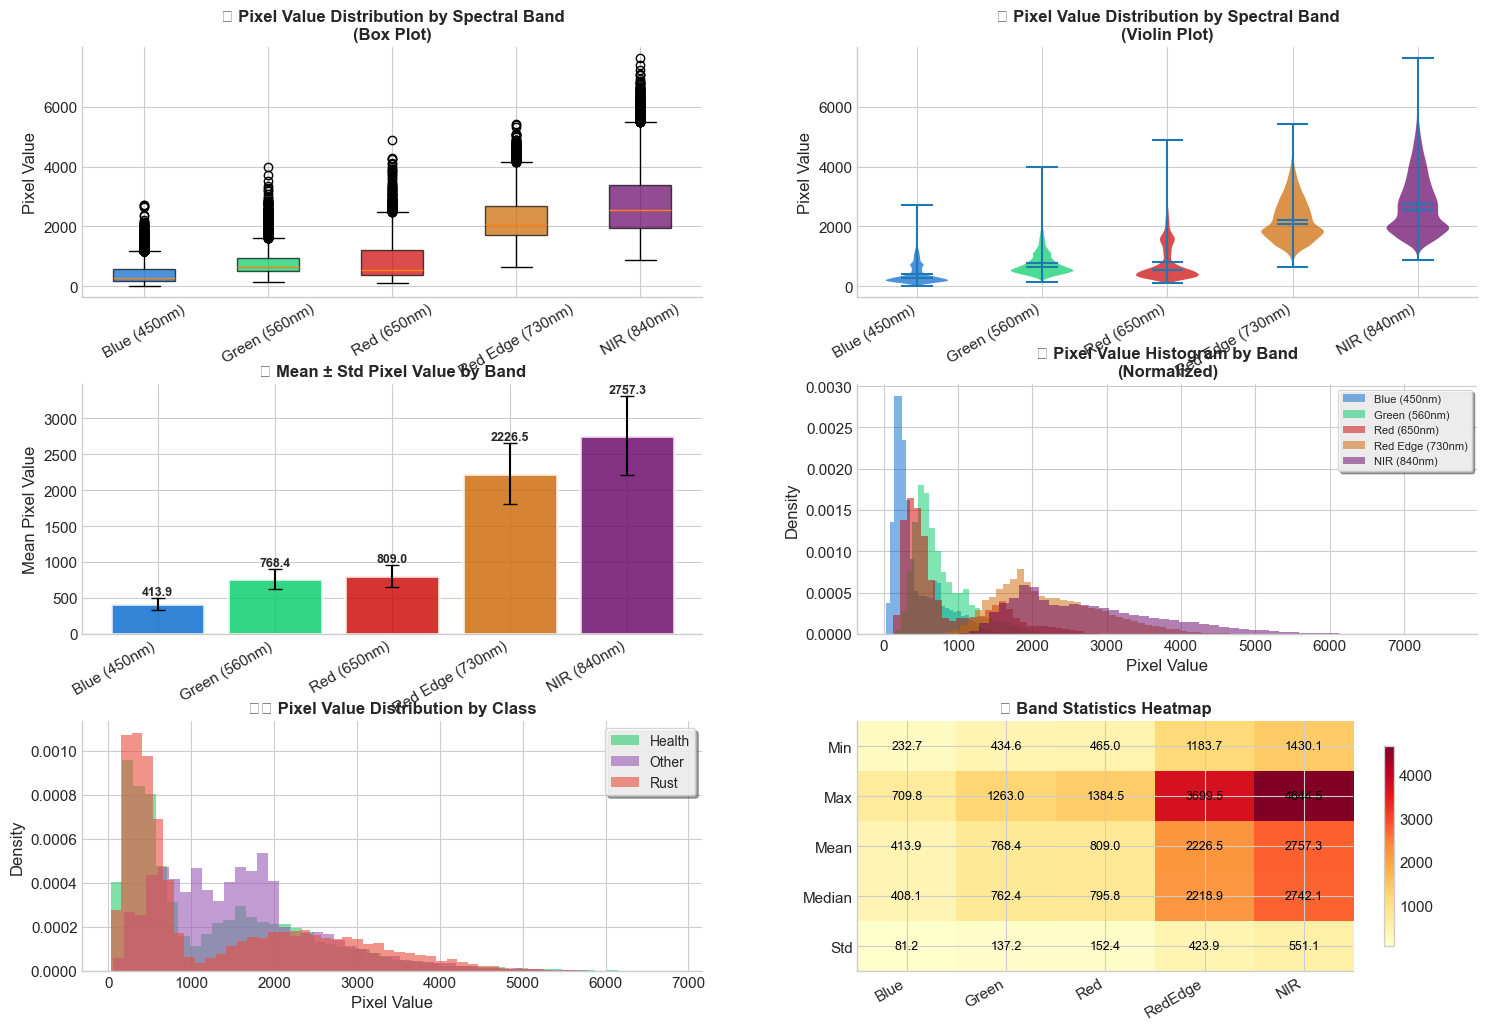

💾 Figure saved: ms_pixel_statistics.png


In [28]:
# ============================================================================
# 📊 PIXEL STATISTICS VISUALIZATION
# ============================================================================

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 2, hspace=0.35, wspace=0.25)

# Band colors matching spectral bands
band_colors = ['#0066CC', '#00CC66', '#CC0000', '#CC6600', '#660066']
band_names = list(MS_BANDS.values())

# --- Chart 1: Box Plot - Pixel Distribution by Band ---
ax1 = fig.add_subplot(gs[0, 0])
box_data = [pixel_by_band[i] for i in range(5)]
bp = ax1.boxplot(box_data, patch_artist=True, labels=band_names)

for patch, color in zip(bp['boxes'], band_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_ylabel('Pixel Value')
ax1.set_title('📦 Pixel Value Distribution by Spectral Band\n(Box Plot)', fontweight='bold', fontsize=12)
ax1.tick_params(axis='x', rotation=30)

# --- Chart 2: Violin Plot - Pixel Distribution by Band ---
ax2 = fig.add_subplot(gs[0, 1])
parts = ax2.violinplot(box_data, positions=range(1, 6), showmeans=True, showmedians=True)

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(band_colors[i])
    pc.set_alpha(0.7)

ax2.set_xticks(range(1, 6))
ax2.set_xticklabels(band_names, rotation=30, ha='right')
ax2.set_ylabel('Pixel Value')
ax2.set_title('🎻 Pixel Value Distribution by Spectral Band\n(Violin Plot)', fontweight='bold', fontsize=12)

# --- Chart 3: Mean ± Std by Band ---
ax3 = fig.add_subplot(gs[1, 0])
means = [np.mean(band_stats[i]['mean']) for i in range(5)]
stds = [np.mean(band_stats[i]['std']) for i in range(5)]

x = np.arange(5)
bars = ax3.bar(x, means, yerr=stds, capsize=5, color=band_colors, 
               edgecolor='white', linewidth=2, alpha=0.8)
ax3.set_xticks(x)
ax3.set_xticklabels(band_names, rotation=30, ha='right')
ax3.set_ylabel('Mean Pixel Value')
ax3.set_title('📊 Mean ± Std Pixel Value by Band', fontweight='bold', fontsize=12)

for bar, mean, std in zip(bars, means, stds):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.5, 
             f'{mean:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# --- Chart 4: Histogram Distribution All Bands ---
ax4 = fig.add_subplot(gs[1, 1])
for i in range(5):
    ax4.hist(pixel_by_band[i], bins=50, alpha=0.5, label=band_names[i], 
             color=band_colors[i], density=True)
ax4.set_xlabel('Pixel Value')
ax4.set_ylabel('Density')
ax4.set_title('📈 Pixel Value Histogram by Band\n(Normalized)', fontweight='bold', fontsize=12)
ax4.legend(loc='upper right', fontsize=8)

# --- Chart 5: Pixel Distribution by Class ---
ax5 = fig.add_subplot(gs[2, 0])
for cls in pixel_by_class.keys():
    ax5.hist(pixel_by_class[cls], bins=50, alpha=0.6, label=cls, 
             color=COLORS[cls], density=True)
ax5.set_xlabel('Pixel Value')
ax5.set_ylabel('Density')
ax5.set_title('🏷️ Pixel Value Distribution by Class', fontweight='bold', fontsize=12)
ax5.legend()

# --- Chart 6: Band Statistics Heatmap ---
ax6 = fig.add_subplot(gs[2, 1])
stats_matrix = np.array([
    [np.mean(band_stats[i]['min']) for i in range(5)],
    [np.mean(band_stats[i]['max']) for i in range(5)],
    [np.mean(band_stats[i]['mean']) for i in range(5)],
    [np.mean(band_stats[i]['median']) for i in range(5)],
    [np.mean(band_stats[i]['std']) for i in range(5)]
])

im = ax6.imshow(stats_matrix, cmap='YlOrRd', aspect='auto')
ax6.set_xticks(range(5))
ax6.set_xticklabels(['Blue', 'Green', 'Red', 'RedEdge', 'NIR'], rotation=30, ha='right')
ax6.set_yticks(range(5))
ax6.set_yticklabels(['Min', 'Max', 'Mean', 'Median', 'Std'])
ax6.set_title('🔥 Band Statistics Heatmap', fontweight='bold', fontsize=12)

# Add text annotations
for i in range(5):
    for j in range(5):
        text = ax6.text(j, i, f'{stats_matrix[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=ax6, shrink=0.8)

plt.tight_layout()
plt.savefig('ms_pixel_statistics.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("💾 Figure saved: ms_pixel_statistics.png")

---
## 🔗 Section 7: Spectral Band Correlation Analysis

> Phân tích mối tương quan giữa các bands spectral - quan trọng cho việc feature selection.

🔍 Calculating band correlations from 30 images...


Processing: 100%|██████████████████████████████| 30/30 [00:00<00:00, 428.20it/s]


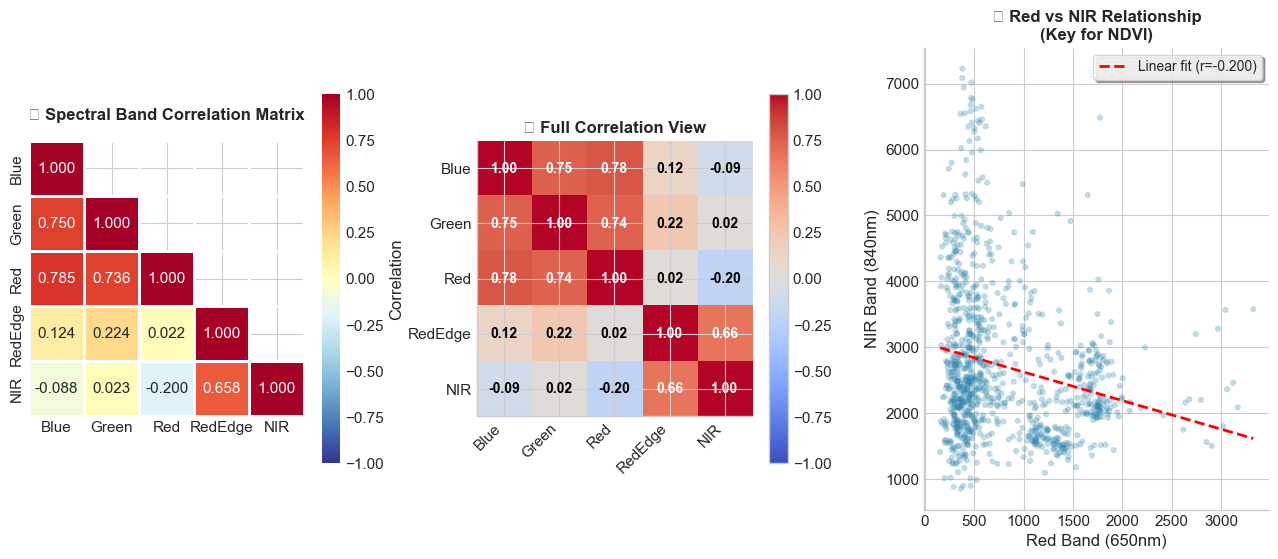

💾 Figure saved: ms_correlation_analysis.png

📊 CORRELATION INSIGHTS
• Highest correlation: Blue ↔ Red (r = 0.785)
• Red-NIR correlation: -0.200 (crucial for vegetation indices)
• Red Edge importance: High correlation with NIR (0.658) indicates vegetation stress detection capability


In [29]:
# ============================================================================
# 🔗 SECTION 7: SPECTRAL BAND CORRELATION ANALYSIS
# ============================================================================

def calculate_band_correlation(df, num_samples=30):
    """
    Tính ma trận tương quan giữa các bands spectral.
    """
    samples = df.sample(min(len(df), num_samples), random_state=42)
    
    all_band_data = {i: [] for i in range(5)}
    
    print(f"🔍 Calculating band correlations from {len(samples)} images...")
    
    for _, row in tqdm(samples.iterrows(), total=len(samples), desc="Processing", ncols=80):
        try:
            img = tiff.imread(row['Path'])
            
            if img.ndim == 3:
                if img.shape[0] > img.shape[2]:
                    img = np.transpose(img, (2, 0, 1))
            
            for band in range(min(img.shape[0], 5)):
                # Sample pixels uniformly
                band_data = img[band].flatten()
                sampled = np.random.choice(band_data, min(200, len(band_data)), replace=False)
                all_band_data[band].extend(sampled)
                
        except Exception as e:
            continue
    
    # Create correlation matrix
    min_len = min(len(all_band_data[i]) for i in range(5))
    band_matrix = np.array([all_band_data[i][:min_len] for i in range(5)])
    corr_matrix = np.corrcoef(band_matrix)
    
    return corr_matrix, band_matrix

corr_matrix, band_matrix = calculate_band_correlation(df_ms)

# Visualization
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(1, 3, wspace=0.3)

band_short_names = ['Blue', 'Green', 'Red', 'RedEdge', 'NIR']

# --- Chart 1: Correlation Heatmap ---
ax1 = fig.add_subplot(gs[0])
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='RdYlBu_r',
            xticklabels=band_short_names, yticklabels=band_short_names,
            vmin=-1, vmax=1, center=0, square=True,
            cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
            ax=ax1, linewidths=2, linecolor='white')
ax1.set_title('🔥 Spectral Band Correlation Matrix', fontweight='bold', fontsize=12, pad=15)

# --- Chart 2: Correlation Clustermap Style ---
ax2 = fig.add_subplot(gs[1])
im = ax2.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_xticks(range(5))
ax2.set_xticklabels(band_short_names, rotation=45, ha='right')
ax2.set_yticks(range(5))
ax2.set_yticklabels(band_short_names)
ax2.set_title('🎯 Full Correlation View', fontweight='bold', fontsize=12)

for i in range(5):
    for j in range(5):
        color = 'white' if abs(corr_matrix[i, j]) > 0.5 else 'black'
        ax2.text(j, i, f'{corr_matrix[i, j]:.2f}', ha='center', va='center', 
                 color=color, fontweight='bold', fontsize=10)

plt.colorbar(im, ax=ax2, shrink=0.8)

# --- Chart 3: Pairwise Scatter (selected pairs) ---
ax3 = fig.add_subplot(gs[2])

# Plot Red vs NIR (important for vegetation indices)
sample_size = min(1000, len(band_matrix[2]))
indices = np.random.choice(len(band_matrix[2]), sample_size, replace=False)

ax3.scatter(band_matrix[2][indices], band_matrix[4][indices], 
            alpha=0.3, s=20, c=COLORS['primary'], edgecolors='none')
ax3.set_xlabel('Red Band (650nm)')
ax3.set_ylabel('NIR Band (840nm)')
ax3.set_title('🌿 Red vs NIR Relationship\n(Key for NDVI)', fontweight='bold', fontsize=12)

# Add regression line
z = np.polyfit(band_matrix[2][indices], band_matrix[4][indices], 1)
p = np.poly1d(z)
x_line = np.linspace(min(band_matrix[2][indices]), max(band_matrix[2][indices]), 100)
ax3.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'Linear fit (r={corr_matrix[2,4]:.3f})')
ax3.legend()

plt.tight_layout()
plt.savefig('ms_correlation_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("💾 Figure saved: ms_correlation_analysis.png")

# Print correlation insights
print("\n" + "=" * 60)
print("📊 CORRELATION INSIGHTS")
print("=" * 60)
print(f"• Highest correlation: {band_short_names[np.unravel_index(np.argmax(corr_matrix - np.eye(5)), (5,5))[0]]} ↔ "
      f"{band_short_names[np.unravel_index(np.argmax(corr_matrix - np.eye(5)), (5,5))[1]]} "
      f"(r = {np.max(corr_matrix - np.eye(5)):.3f})")
print(f"• Red-NIR correlation: {corr_matrix[2,4]:.3f} (crucial for vegetation indices)")
print(f"• Red Edge importance: High correlation with NIR ({corr_matrix[3,4]:.3f}) indicates vegetation stress detection capability")

---
## 🖼️ Section 8: Sample Image Visualization

> Hiển thị mẫu ảnh từ mỗi class với tất cả các bands spectral.

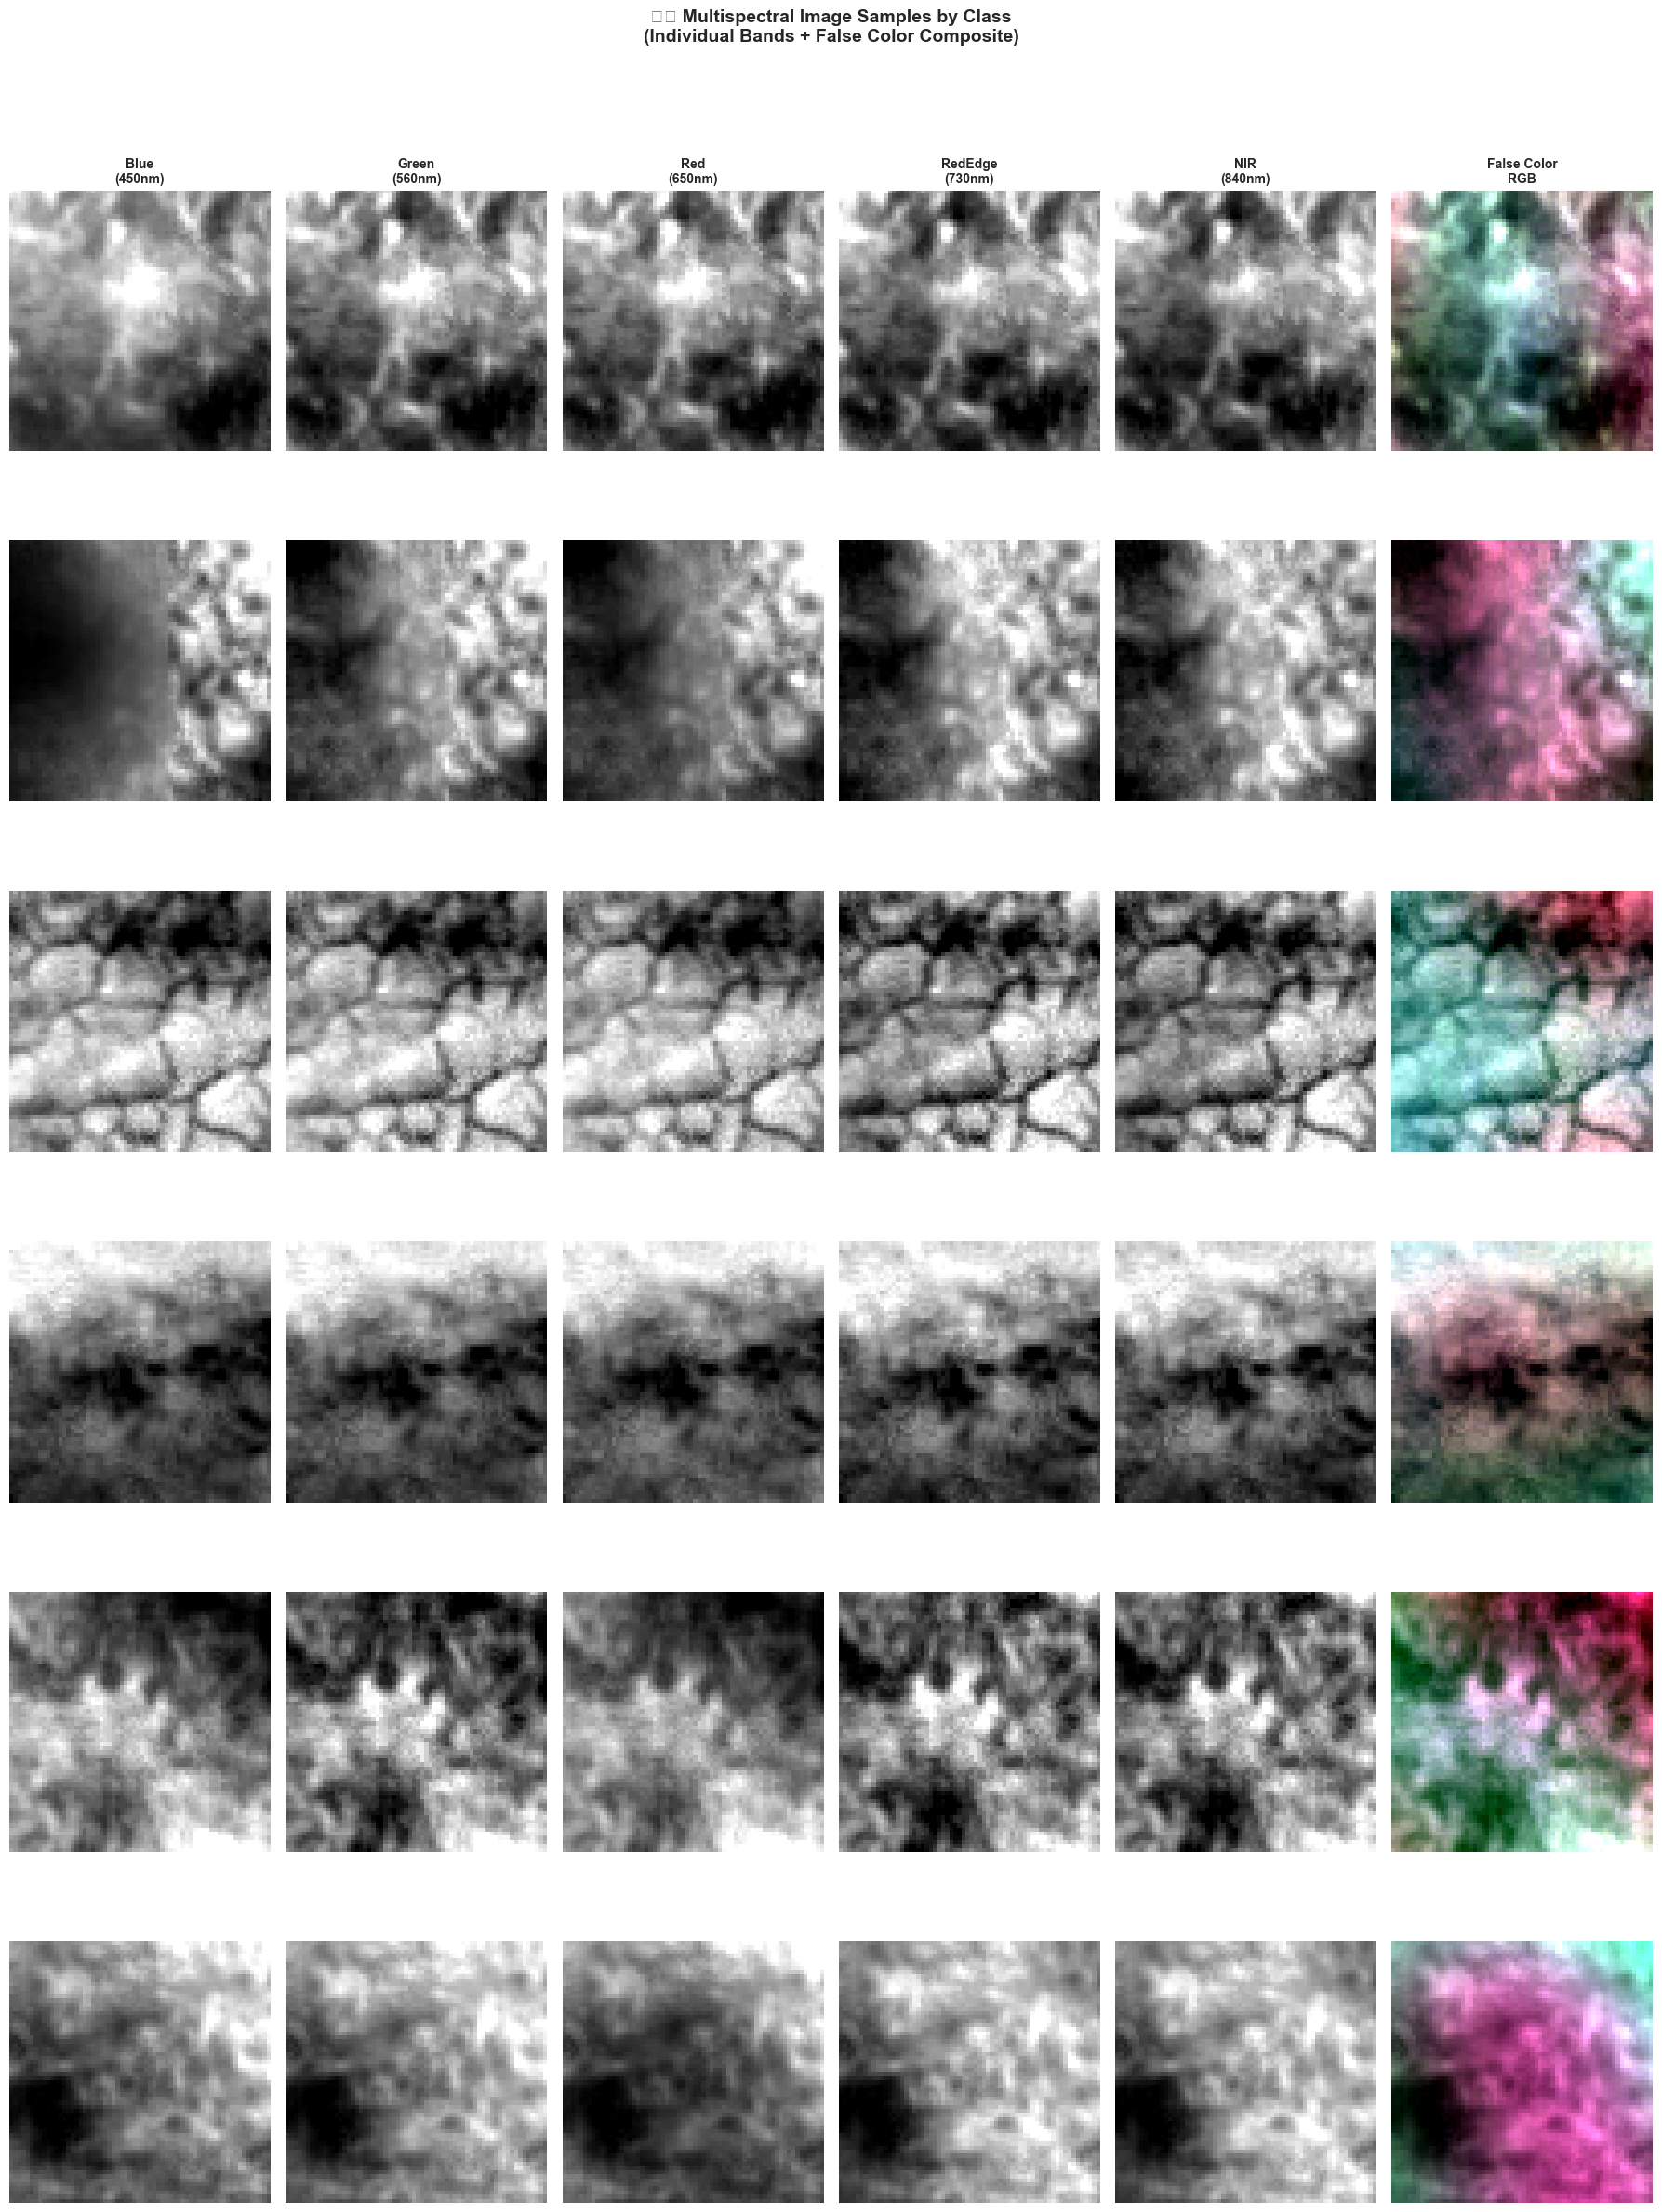

💾 Figure saved: ms_sample_visualization.png


In [30]:
# ============================================================================
# 🖼️ SECTION 8: SAMPLE IMAGE VISUALIZATION
# ============================================================================

def visualize_ms_samples(df, samples_per_class=2):
    """
    Hiển thị mẫu ảnh MS với tất cả bands cho mỗi class.
    """
    classes = df['Class'].unique()
    n_classes = len(classes)
    n_bands = 5
    
    fig, axes = plt.subplots(n_classes * samples_per_class, n_bands + 1, 
                              figsize=(18, 4 * n_classes * samples_per_class))
    
    band_names = ['Blue\n(450nm)', 'Green\n(560nm)', 'Red\n(650nm)', 
                  'RedEdge\n(730nm)', 'NIR\n(840nm)', 'False Color\nRGB']
    
    row_idx = 0
    for cls in classes:
        class_samples = df[df['Class'] == cls].sample(min(samples_per_class, len(df[df['Class'] == cls])), 
                                                       random_state=42)
        
        for _, sample in class_samples.iterrows():
            try:
                img = tiff.imread(sample['Path'])
                
                # Normalize to CHW
                if img.ndim == 3 and img.shape[0] > img.shape[2]:
                    img = np.transpose(img, (2, 0, 1))
                
                # Display each band
                for band in range(min(img.shape[0], 5)):
                    ax = axes[row_idx, band]
                    band_data = img[band].astype(np.float32)
                    
                    # Normalize for display
                    vmin, vmax = np.percentile(band_data, [2, 98])
                    band_normalized = np.clip((band_data - vmin) / (vmax - vmin + 1e-8), 0, 1)
                    
                    ax.imshow(band_normalized, cmap='gray')
                    ax.axis('off')
                    
                    if row_idx == 0:
                        ax.set_title(band_names[band], fontsize=10, fontweight='bold')
                    
                    if band == 0:
                        ax.set_ylabel(f"{cls}\n{sample['File Name'][:15]}...", 
                                     fontsize=9, fontweight='bold', rotation=0, 
                                     labelpad=60, va='center')
                
                # Create false color composite (NIR-R-G as RGB)
                ax = axes[row_idx, 5]
                if img.shape[0] >= 5:
                    nir = img[4].astype(np.float32)
                    red = img[2].astype(np.float32)
                    green = img[1].astype(np.float32)
                    
                    # Normalize each channel
                    def normalize_band(b):
                        vmin, vmax = np.percentile(b, [2, 98])
                        return np.clip((b - vmin) / (vmax - vmin + 1e-8), 0, 1)
                    
                    false_color = np.stack([normalize_band(nir), 
                                           normalize_band(red), 
                                           normalize_band(green)], axis=-1)
                    ax.imshow(false_color)
                ax.axis('off')
                if row_idx == 0:
                    ax.set_title(band_names[5], fontsize=10, fontweight='bold')
                
                row_idx += 1
                
            except Exception as e:
                print(f"Error loading {sample['File Name']}: {e}")
                row_idx += 1
                continue
    
    plt.suptitle('🖼️ Multispectral Image Samples by Class\n(Individual Bands + False Color Composite)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('ms_sample_visualization.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("💾 Figure saved: ms_sample_visualization.png")

# Hiển thị samples
visualize_ms_samples(df_ms, samples_per_class=2)

---
## 🔍 Section 8.1: Chi tiết 5 Bands của ảnh MS

> Xem chi tiết từng band của ảnh Multispectral (giữ nguyên 5 lớp).

🖼️  Hiển thị 3 ảnh MS với 5 bands chi tiết:

📸 Ảnh 1: Health_hyper_62.tif (Class: Health)
   📐 Shape: (5, 64, 64) (Channels=5, Height=64, Width=64)
   🔢 Dtype: uint16, Range: [47, 4218]


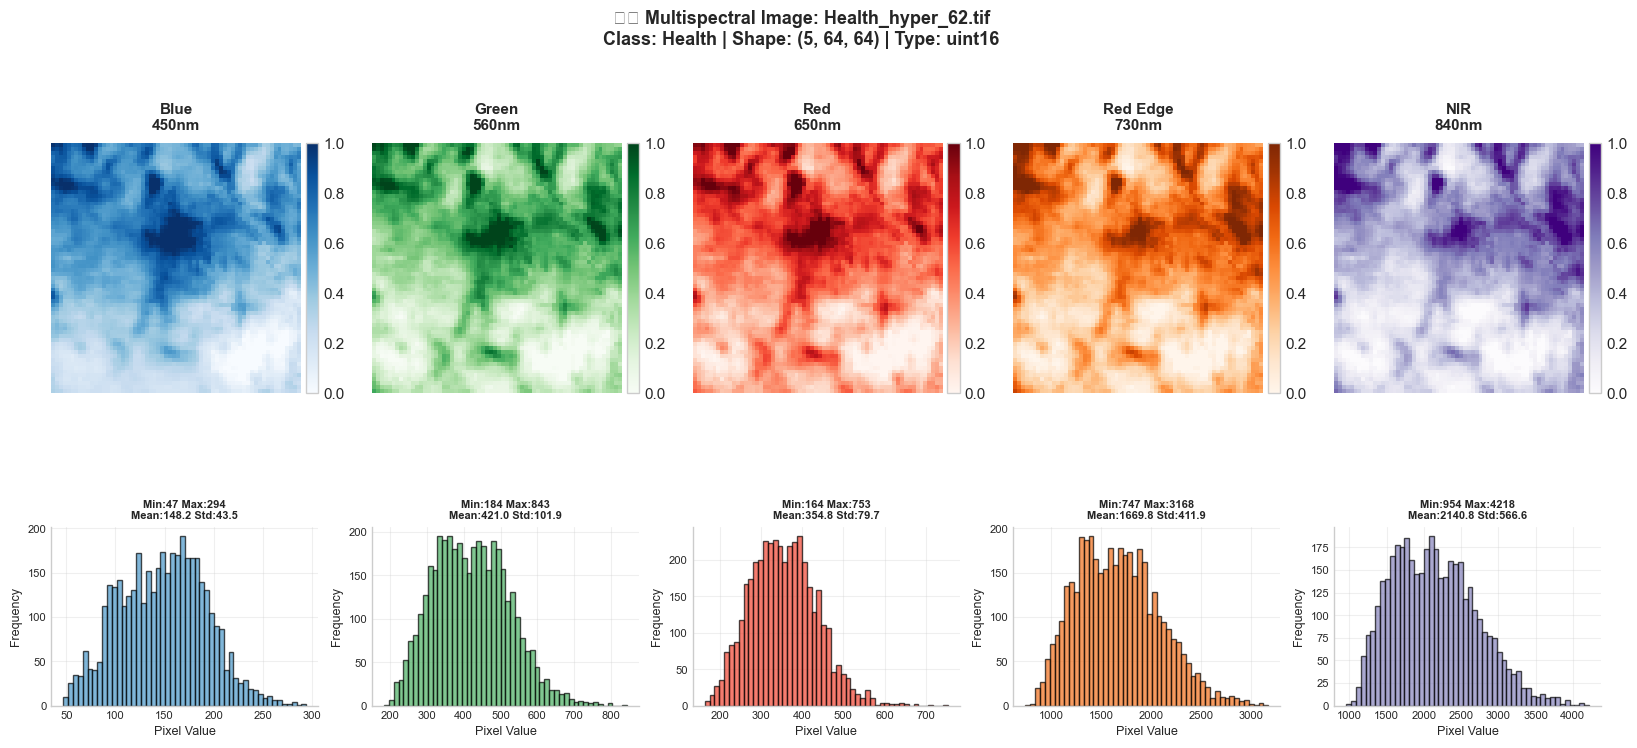


   📊 Thống kê chi tiết từng band:
      Band 0 (Blue - 450nm): min=   47.0, max=  294.0, mean=  148.2, std=  43.5
      Band 1 (Green - 560nm): min=  184.0, max=  843.0, mean=  421.0, std= 101.9
      Band 2 (Red - 650nm): min=  164.0, max=  753.0, mean=  354.8, std=  79.7
      Band 3 (Red Edge - 730nm): min=  747.0, max= 3168.0, mean= 1669.8, std= 411.9
      Band 4 (NIR - 840nm): min=  954.0, max= 4218.0, mean= 2140.8, std= 566.6

📸 Ảnh 2: Other_hyper_30.tif (Class: Other)
   📐 Shape: (5, 64, 64) (Channels=5, Height=64, Width=64)
   🔢 Dtype: uint16, Range: [630, 3783]


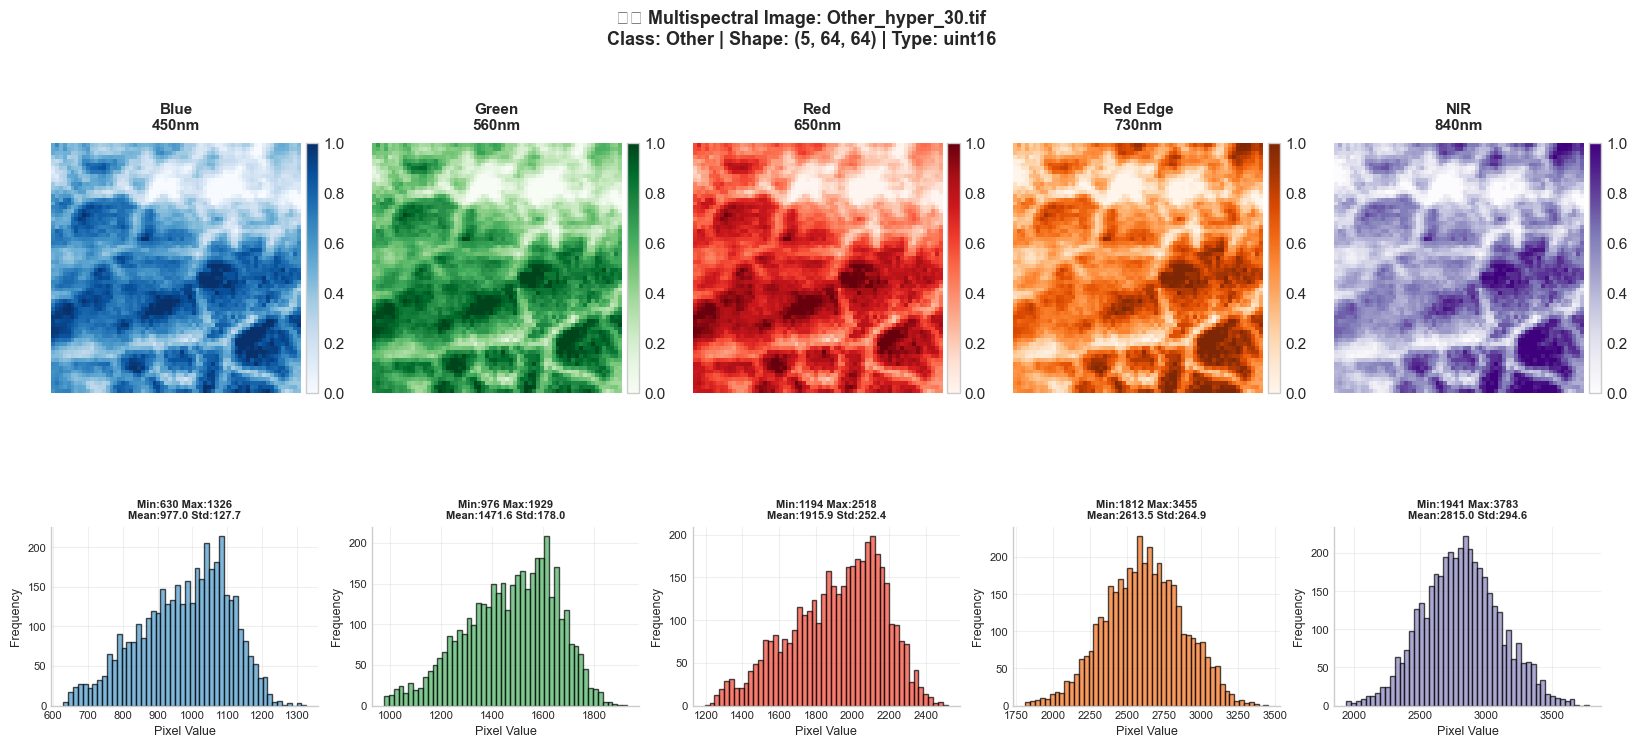


   📊 Thống kê chi tiết từng band:
      Band 0 (Blue - 450nm): min=  630.0, max= 1326.0, mean=  977.0, std= 127.7
      Band 1 (Green - 560nm): min=  976.0, max= 1929.0, mean= 1471.6, std= 178.0
      Band 2 (Red - 650nm): min= 1194.0, max= 2518.0, mean= 1915.9, std= 252.4
      Band 3 (Red Edge - 730nm): min= 1812.0, max= 3455.0, mean= 2613.5, std= 264.9
      Band 4 (NIR - 840nm): min= 1941.0, max= 3783.0, mean= 2815.0, std= 294.6

📸 Ảnh 3: Rust_hyper_185.tif (Class: Rust)
   📐 Shape: (5, 64, 64) (Channels=5, Height=64, Width=64)
   🔢 Dtype: uint16, Range: [75, 3835]


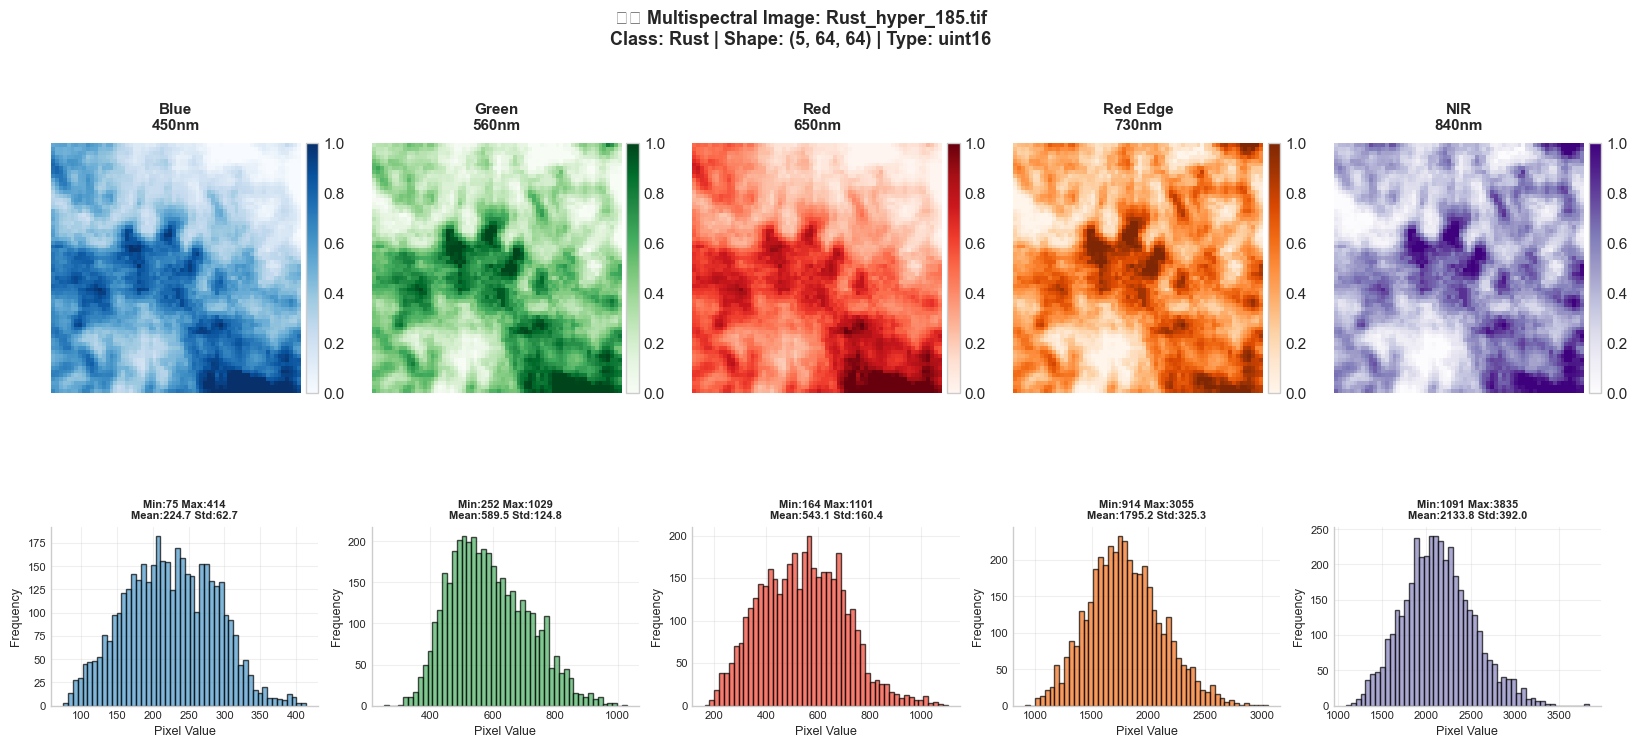


   📊 Thống kê chi tiết từng band:
      Band 0 (Blue - 450nm): min=   75.0, max=  414.0, mean=  224.7, std=  62.7
      Band 1 (Green - 560nm): min=  252.0, max= 1029.0, mean=  589.5, std= 124.8
      Band 2 (Red - 650nm): min=  164.0, max= 1101.0, mean=  543.1, std= 160.4
      Band 3 (Red Edge - 730nm): min=  914.0, max= 3055.0, mean= 1795.2, std= 325.3
      Band 4 (NIR - 840nm): min= 1091.0, max= 3835.0, mean= 2133.8, std= 392.0

✅ Hoàn thành visualization chi tiết 5 bands!


In [31]:
# ============================================================================
# 🔍 SECTION 8.1: VISUALIZE MS IMAGE WITH ALL 5 BANDS
# ============================================================================

def visualize_ms_bands_detail(df, n_samples=3):
    """
    Hiển thị chi tiết 5 bands của ảnh MS - mỗi band trên một subplot.
    
    Parameters:
    -----------
    df : pd.DataFrame - DataFrame chứa metadata ảnh
    n_samples : int - Số lượng ảnh mẫu để hiển thị
    """
    
    # Lấy mẫu ngẫu nhiên từ mỗi class
    samples = []
    for cls in df['Class'].unique():
        class_df = df[df['Class'] == cls]
        sample = class_df.sample(min(1, len(class_df)), random_state=42)
        samples.append(sample)
    
    samples_df = pd.concat(samples).head(n_samples)
    
    # Thông tin về các bands
    band_info = [
        ('Blue', '450nm', 'Blues'),
        ('Green', '560nm', 'Greens'),
        ('Red', '650nm', 'Reds'),
        ('Red Edge', '730nm', 'Oranges'),
        ('NIR', '840nm', 'Purples')
    ]
    
    print(f"🖼️  Hiển thị {len(samples_df)} ảnh MS với 5 bands chi tiết:")
    print("=" * 80)
    
    for idx, (_, row) in enumerate(samples_df.iterrows()):
        print(f"\n📸 Ảnh {idx+1}: {row['File Name']} (Class: {row['Class']})")
        
        try:
            # Load ảnh
            img = tiff.imread(row['Path'])
            
            # Chuyển về CHW nếu cần
            if img.ndim == 3:
                if img.shape[0] > img.shape[2]:
                    # HWC -> CHW
                    img = np.transpose(img, (2, 0, 1))
            else:
                print(f"   ⚠️  Ảnh không đúng format 3D: {img.shape}")
                continue
            
            c, h, w = img.shape
            print(f"   📐 Shape: {img.shape} (Channels={c}, Height={h}, Width={w})")
            print(f"   🔢 Dtype: {img.dtype}, Range: [{img.min()}, {img.max()}]")
            
            # Tạo figure với 2 hàng
            # Hàng 1: 5 bands riêng lẻ (grayscale)
            # Hàng 2: Histogram và thống kê cho mỗi band
            fig = plt.figure(figsize=(20, 8))
            gs = GridSpec(2, 5, height_ratios=[2, 1], hspace=0.3, wspace=0.2)
            
            # Hiển thị từng band
            for band_idx in range(min(c, 5)):
                band_name, wavelength, cmap = band_info[band_idx]
                band_data = img[band_idx].astype(np.float32)
                
                # Stats
                band_min = band_data.min()
                band_max = band_data.max()
                band_mean = band_data.mean()
                band_std = band_data.std()
                
                # Subplot 1: Band image
                ax_img = fig.add_subplot(gs[0, band_idx])
                
                # Normalize để hiển thị tốt hơn (2-98 percentile)
                vmin, vmax = np.percentile(band_data, [2, 98])
                band_normalized = np.clip((band_data - vmin) / (vmax - vmin + 1e-8), 0, 1)
                
                im = ax_img.imshow(band_normalized, cmap=cmap)
                ax_img.set_title(f'{band_name}\n{wavelength}', 
                               fontsize=11, fontweight='bold', pad=10)
                ax_img.axis('off')
                
                # Thêm colorbar nhỏ
                from mpl_toolkits.axes_grid1 import make_axes_locatable
                divider = make_axes_locatable(ax_img)
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax=cax)
                
                # Subplot 2: Histogram
                ax_hist = fig.add_subplot(gs[1, band_idx])
                ax_hist.hist(band_data.flatten(), bins=50, color=plt.cm.get_cmap(cmap)(0.6), 
                           alpha=0.7, edgecolor='black')
                ax_hist.set_xlabel('Pixel Value', fontsize=9)
                ax_hist.set_ylabel('Frequency', fontsize=9)
                ax_hist.set_title(f'Min:{band_min:.0f} Max:{band_max:.0f}\n'
                                f'Mean:{band_mean:.1f} Std:{band_std:.1f}', 
                                fontsize=8)
                ax_hist.tick_params(labelsize=8)
                ax_hist.grid(True, alpha=0.3)
            
            plt.suptitle(f'🛰️ Multispectral Image: {row["File Name"]}\n'
                        f'Class: {row["Class"]} | Shape: {img.shape} | Type: {img.dtype}',
                        fontsize=13, fontweight='bold', y=0.98)
            
            plt.savefig(f'ms_bands_detail_{idx+1}.png', dpi=150, bbox_inches='tight', 
                       facecolor='white')
            plt.show()
            
            # In thêm thống kê chi tiết
            print(f"\n   📊 Thống kê chi tiết từng band:")
            for band_idx in range(min(c, 5)):
                band_name, wavelength, _ = band_info[band_idx]
                band_data = img[band_idx]
                print(f"      Band {band_idx} ({band_name} - {wavelength}): "
                      f"min={band_data.min():7.1f}, max={band_data.max():7.1f}, "
                      f"mean={band_data.mean():7.1f}, std={band_data.std():6.1f}")
            
        except Exception as e:
            print(f"   ❌ Lỗi khi xử lý ảnh: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print("\n" + "=" * 80)
    print("✅ Hoàn thành visualization chi tiết 5 bands!")

# Chạy visualization
visualize_ms_bands_detail(df_ms, n_samples=3)

---
## 📊 Section 9: Vegetation Indices Analysis

> Tính toán và phân tích các chỉ số thực vật (NDVI, NDRE) - quan trọng cho phát hiện bệnh cây.

🌿 Calculating vegetation indices from 60 samples...


Computing indices:   0%|                                 | 0/60 [00:00<?, ?it/s]

Computing indices: 100%|███████████████████████| 60/60 [00:00<00:00, 614.71it/s]


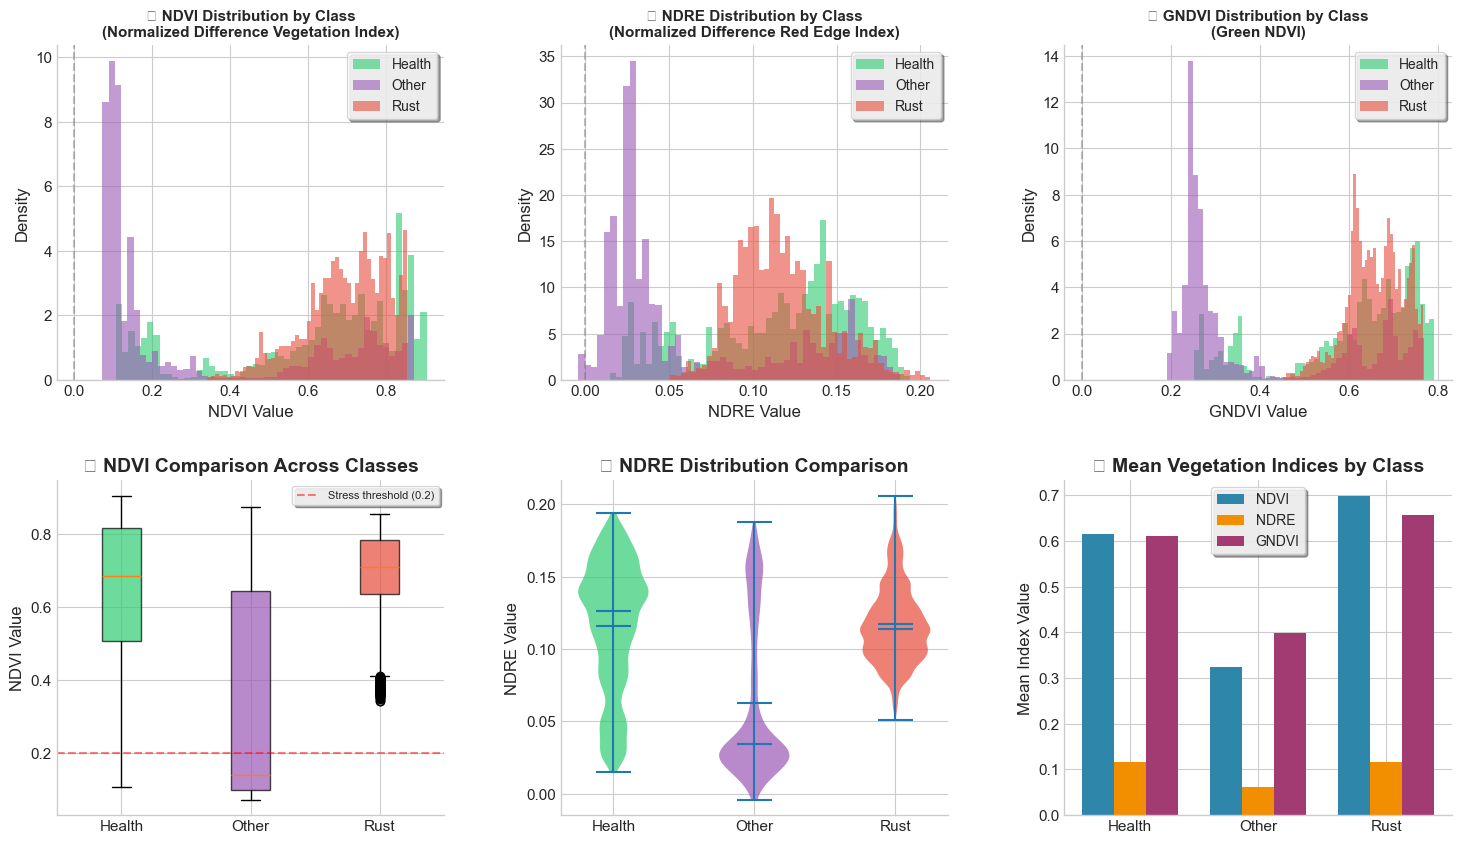

💾 Figure saved: ms_vegetation_indices.png

🌿 VEGETATION INDICES SUMMARY

Health:
  • NDVI:  Mean = 0.6154, Std = 0.2415
  • NDRE:  Mean = 0.1155, Std = 0.0449
  • GNDVI: Mean = 0.6101, Std = 0.1529
  • GNDVI: Mean = 0.6101, Std = 0.1529

Other:
  • NDVI:  Mean = 0.3250, Std = 0.2910
  • NDRE:  Mean = 0.0627, Std = 0.0542
  • GNDVI: Mean = 0.3985, Std = 0.1946
  • GNDVI: Mean = 0.3985, Std = 0.1946

Rust:
  • NDVI:  Mean = 0.6979, Std = 0.1056
  • NDRE:  Mean = 0.1170, Std = 0.0270
  • GNDVI: Mean = 0.6571, Std = 0.0630
  • GNDVI: Mean = 0.6571, Std = 0.0630


In [32]:
# ============================================================================
# 📊 SECTION 9: VEGETATION INDICES ANALYSIS
# ============================================================================

def calculate_vegetation_indices(df, num_samples=50):
    """
    Tính các chỉ số thực vật từ ảnh MS.
    
    NDVI = (NIR - Red) / (NIR + Red)
    NDRE = (NIR - RedEdge) / (NIR + RedEdge)
    GNDVI = (NIR - Green) / (NIR + Green)
    """
    
    results = {'Class': [], 'NDVI_mean': [], 'NDVI_std': [], 
               'NDRE_mean': [], 'NDRE_std': [], 'GNDVI_mean': [], 'GNDVI_std': []}
    
    ndvi_by_class = {cls: [] for cls in df['Class'].unique()}
    ndre_by_class = {cls: [] for cls in df['Class'].unique()}
    gndvi_by_class = {cls: [] for cls in df['Class'].unique()}
    
    samples = df.groupby('Class', group_keys=False).apply(
        lambda x: x.sample(min(len(x), num_samples // df['Class'].nunique()), random_state=42)
    ).reset_index(drop=True)
    
    print(f"🌿 Calculating vegetation indices from {len(samples)} samples...")
    
    for _, row in tqdm(samples.iterrows(), total=len(samples), desc="Computing indices", ncols=80):
        try:
            img = tiff.imread(row['Path']).astype(np.float32)
            
            if img.ndim == 3 and img.shape[0] > img.shape[2]:
                img = np.transpose(img, (2, 0, 1))
            
            if img.shape[0] < 5:
                continue
                
            green = img[1]
            red = img[2]
            red_edge = img[3]
            nir = img[4]
            
            # Avoid division by zero
            eps = 1e-8
            
            ndvi = (nir - red) / (nir + red + eps)
            ndre = (nir - red_edge) / (nir + red_edge + eps)
            gndvi = (nir - green) / (nir + green + eps)
            
            ndvi_by_class[row['Class']].extend(ndvi.flatten()[:500])
            ndre_by_class[row['Class']].extend(ndre.flatten()[:500])
            gndvi_by_class[row['Class']].extend(gndvi.flatten()[:500])
            
        except Exception as e:
            continue
    
    return ndvi_by_class, ndre_by_class, gndvi_by_class

ndvi_data, ndre_data, gndvi_data = calculate_vegetation_indices(df_ms, num_samples=60)

# Visualization
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 3, hspace=0.3, wspace=0.3)

# Dynamic class_order từ dữ liệu thực tế
class_order = [cls for cls in ['Health', 'Other', 'Rust'] if cls in ndvi_data]
colors = [COLORS.get(cls, '#999999') for cls in class_order]

# --- Chart 1: NDVI Distribution ---
ax1 = fig.add_subplot(gs[0, 0])
for cls, color in zip(class_order, colors):
    if cls in ndvi_data and len(ndvi_data[cls]) > 0:
        ax1.hist(ndvi_data[cls], bins=50, alpha=0.6, label=cls, color=color, density=True)
ax1.set_xlabel('NDVI Value')
ax1.set_ylabel('Density')
ax1.set_title('🌿 NDVI Distribution by Class\n(Normalized Difference Vegetation Index)', 
              fontweight='bold', fontsize=11)
ax1.legend()
ax1.axvline(0, color='gray', linestyle='--', alpha=0.5)

# --- Chart 2: NDRE Distribution ---
ax2 = fig.add_subplot(gs[0, 1])
for cls, color in zip(class_order, colors):
    if cls in ndre_data and len(ndre_data[cls]) > 0:
        ax2.hist(ndre_data[cls], bins=50, alpha=0.6, label=cls, color=color, density=True)
ax2.set_xlabel('NDRE Value')
ax2.set_ylabel('Density')
ax2.set_title('🔴 NDRE Distribution by Class\n(Normalized Difference Red Edge Index)', 
              fontweight='bold', fontsize=11)
ax2.legend()
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5)

# --- Chart 3: GNDVI Distribution ---
ax3 = fig.add_subplot(gs[0, 2])
for cls, color in zip(class_order, colors):
    if cls in gndvi_data and len(gndvi_data[cls]) > 0:
        ax3.hist(gndvi_data[cls], bins=50, alpha=0.6, label=cls, color=color, density=True)
ax3.set_xlabel('GNDVI Value')
ax3.set_ylabel('Density')
ax3.set_title('💚 GNDVI Distribution by Class\n(Green NDVI)', fontweight='bold', fontsize=11)
ax3.legend()
ax3.axvline(0, color='gray', linestyle='--', alpha=0.5)

# --- Chart 4: Box Plot Comparison ---
ax4 = fig.add_subplot(gs[1, 0])
box_labels = [cls for cls in class_order if cls in ndvi_data]
box_data_ndvi = [ndvi_data[cls] for cls in class_order if cls in ndvi_data]
bp = ax4.boxplot(box_data_ndvi, patch_artist=True, labels=box_labels)
for patch, color in zip(bp['boxes'], colors[:len(box_data_ndvi)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax4.set_ylabel('NDVI Value')
ax4.set_title('📦 NDVI Comparison Across Classes', fontweight='bold')
ax4.axhline(0.2, color='red', linestyle='--', alpha=0.5, label='Stress threshold (0.2)')
ax4.legend(fontsize=8)

# --- Chart 5: Violin Plot NDRE ---
ax5 = fig.add_subplot(gs[1, 1])
box_data_ndre = [ndre_data[cls] for cls in class_order if cls in ndre_data]
parts = ax5.violinplot(box_data_ndre, positions=range(len(class_order)), showmeans=True, showmedians=True)
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)
ax5.set_xticks(range(len(class_order)))
ax5.set_xticklabels(class_order)
ax5.set_ylabel('NDRE Value')
ax5.set_title('🎻 NDRE Distribution Comparison', fontweight='bold')

# --- Chart 6: Mean Index Comparison ---
ax6 = fig.add_subplot(gs[1, 2])
x = np.arange(len(class_order))
width = 0.25

means_ndvi = [np.mean(ndvi_data[cls]) if cls in ndvi_data else 0 for cls in class_order]
means_ndre = [np.mean(ndre_data[cls]) if cls in ndre_data else 0 for cls in class_order]
means_gndvi = [np.mean(gndvi_data[cls]) if cls in gndvi_data else 0 for cls in class_order]

bars1 = ax6.bar(x - width, means_ndvi, width, label='NDVI', color=COLORS['primary'])
bars2 = ax6.bar(x, means_ndre, width, label='NDRE', color=COLORS['accent'])
bars3 = ax6.bar(x + width, means_gndvi, width, label='GNDVI', color=COLORS['secondary'])

ax6.set_xticks(x)
ax6.set_xticklabels(class_order)
ax6.set_ylabel('Mean Index Value')
ax6.set_title('📊 Mean Vegetation Indices by Class', fontweight='bold')
ax6.legend()

plt.tight_layout()
plt.savefig('ms_vegetation_indices.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("💾 Figure saved: ms_vegetation_indices.png")

# Statistics Summary
print("\n" + "=" * 70)
print("🌿 VEGETATION INDICES SUMMARY")
print("=" * 70)
for cls in class_order:
    if cls in ndvi_data and len(ndvi_data[cls]) > 0:
        print(f"\n{cls}:")
        print(f"  • NDVI:  Mean = {np.mean(ndvi_data[cls]):.4f}, Std = {np.std(ndvi_data[cls]):.4f}")
        print(f"  • NDRE:  Mean = {np.mean(ndre_data[cls]):.4f}, Std = {np.std(ndre_data[cls]):.4f}")

        print(f"  • GNDVI: Mean = {np.mean(gndvi_data[cls]):.4f}, Std = {np.std(gndvi_data[cls]):.4f}")
        print(f"  • GNDVI: Mean = {np.mean(gndvi_data[cls]):.4f}, Std = {np.std(gndvi_data[cls]):.4f}")

---
## ⚠️ Section 10: Data Quality & Anomaly Detection

> Kiểm tra chất lượng dữ liệu và phát hiện các ảnh bất thường.

📋 DATA QUALITY REPORT - MULTISPECTRAL IMAGES


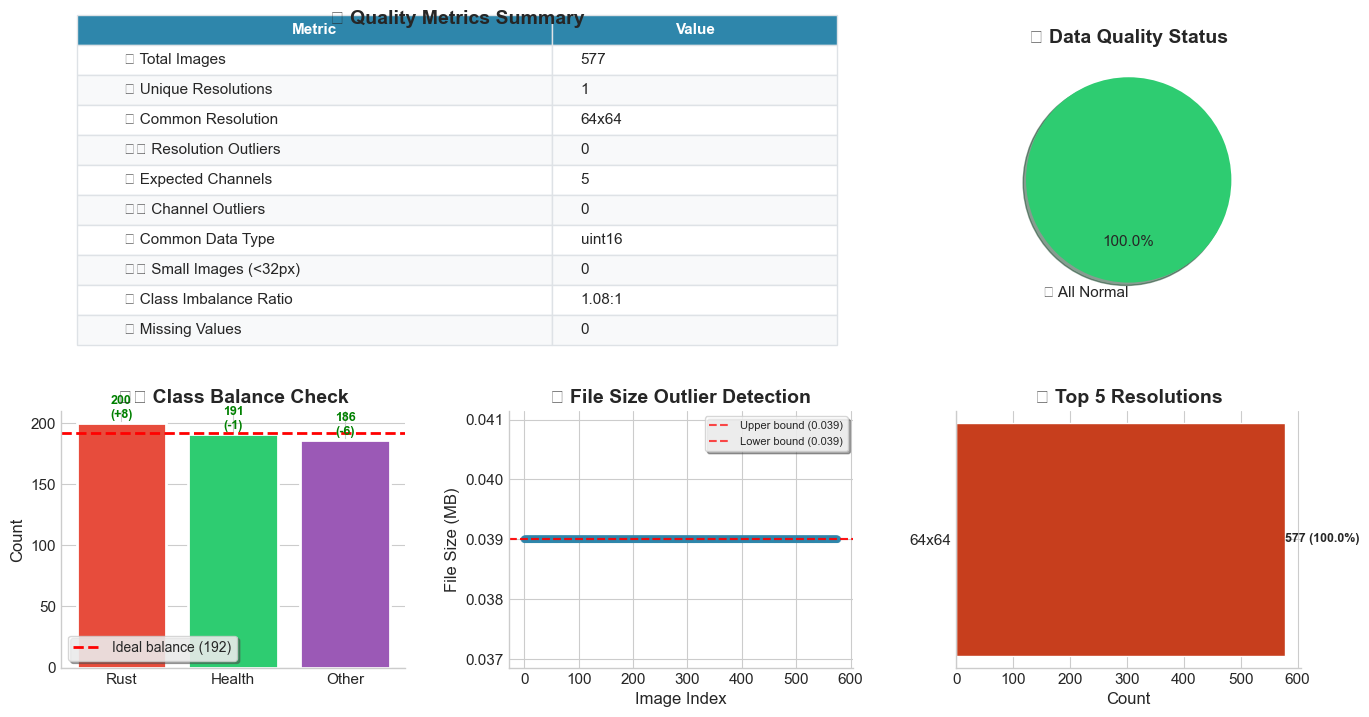

💾 Figure saved: ms_quality_report.png

✅ No anomalies detected! All images are consistent.


In [33]:
# ============================================================================
# ⚠️ SECTION 10: DATA QUALITY & ANOMALY DETECTION
# ============================================================================

def generate_quality_report(df):
    """
    Tạo báo cáo chất lượng dữ liệu chi tiết.
    """
    quality_issues = []
    
    # Check for dimension consistency
    common_resolution = df['Resolution'].mode().iloc[0] if not df.empty else None
    resolution_outliers = df[df['Resolution'] != common_resolution]
    
    # Check for channel consistency
    expected_channels = 5
    channel_outliers = df[df['Channels'] != expected_channels]
    
    # Check for data type consistency
    common_dtype = df['Dtype'].mode().iloc[0] if not df.empty else None
    dtype_outliers = df[df['Dtype'] != common_dtype]
    
    # Check for very small images
    small_images = df[(df['Height'] < 32) | (df['Width'] < 32)]
    
    # Check for aspect ratio issues
    aspect_outliers = df[(df['Aspect Ratio'] < 0.5) | (df['Aspect Ratio'] > 2.0)]
    
    # Check for class imbalance
    class_counts = df['Class'].value_counts()
    max_ratio = class_counts.max() / class_counts.min() if class_counts.min() > 0 else float('inf')
    
    report = {
        'Total Images': len(df),
        'Unique Resolutions': df['Resolution'].nunique(),
        'Common Resolution': common_resolution,
        'Resolution Outliers': len(resolution_outliers),
        'Expected Channels': expected_channels,
        'Channel Outliers': len(channel_outliers),
        'Common Data Type': common_dtype,
        'Dtype Outliers': len(dtype_outliers),
        'Small Images (<32px)': len(small_images),
        'Aspect Ratio Outliers': len(aspect_outliers),
        'Class Imbalance Ratio': f'{max_ratio:.2f}:1',
        'Missing Values': df.isnull().sum().sum()
    }
    
    return report, resolution_outliers, channel_outliers, small_images

report, res_outliers, ch_outliers, small_imgs = generate_quality_report(df_ms)

# Display Quality Report
print("=" * 70)
print("📋 DATA QUALITY REPORT - MULTISPECTRAL IMAGES")
print("=" * 70)

# Create visual report
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 3, hspace=0.4, wspace=0.3)

# --- Chart 1: Quality Metrics Dashboard ---
ax1 = fig.add_subplot(gs[0, :2])
ax1.axis('off')

# Create table data
table_data = [
    ['📊 Total Images', str(report['Total Images'])],
    ['📐 Unique Resolutions', str(report['Unique Resolutions'])],
    ['📐 Common Resolution', str(report['Common Resolution'])],
    ['⚠️ Resolution Outliers', str(report['Resolution Outliers'])],
    ['🔬 Expected Channels', str(report['Expected Channels'])],
    ['⚠️ Channel Outliers', str(report['Channel Outliers'])],
    ['🔢 Common Data Type', str(report['Common Data Type'])],
    ['⚠️ Small Images (<32px)', str(report['Small Images (<32px)'])],
    ['📊 Class Imbalance Ratio', str(report['Class Imbalance Ratio'])],
    ['❌ Missing Values', str(report['Missing Values'])]
]

table = ax1.table(cellText=table_data, 
                  colLabels=['Metric', 'Value'],
                  cellLoc='left',
                  loc='center',
                  colWidths=[0.5, 0.3])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Style header
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(fontweight='bold', color='white')
        cell.set_facecolor(COLORS['primary'])
    elif row % 2 == 0:
        cell.set_facecolor('#f8f9fa')
    cell.set_edgecolor('#dee2e6')

ax1.set_title('📋 Quality Metrics Summary', fontsize=14, fontweight='bold', pad=20)

# --- Chart 2: Quality Status Pie ---
ax2 = fig.add_subplot(gs[0, 2])
quality_good = report['Total Images'] - report['Resolution Outliers'] - report['Channel Outliers'] - report['Small Images (<32px)']
quality_bad = report['Resolution Outliers'] + report['Channel Outliers'] + report['Small Images (<32px)']

if quality_bad > 0:
    sizes = [quality_good, quality_bad]
    labels = ['✅ Normal', '⚠️ Anomalies']
    colors_pie = ['#2ECC71', '#E74C3C']
    explode = (0, 0.1)
else:
    sizes = [quality_good]
    labels = ['✅ All Normal']
    colors_pie = ['#2ECC71']
    explode = (0,)

ax2.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors_pie, 
        explode=explode, shadow=True, startangle=90)
ax2.set_title('🎯 Data Quality Status', fontweight='bold')

# --- Chart 3: Class Balance Check ---
ax3 = fig.add_subplot(gs[1, 0])
class_counts = df_ms['Class'].value_counts()
ideal_count = len(df_ms) / len(class_counts)

bars = ax3.bar(class_counts.index, class_counts.values, 
               color=[COLORS[c] for c in class_counts.index], edgecolor='white', linewidth=2)
ax3.axhline(ideal_count, color='red', linestyle='--', linewidth=2, label=f'Ideal balance ({ideal_count:.0f})')
ax3.set_ylabel('Count')
ax3.set_title('⚖️ Class Balance Check', fontweight='bold')
ax3.legend()

for bar, val in zip(bars, class_counts.values):
    diff = val - ideal_count
    color = 'green' if abs(diff) < ideal_count * 0.1 else 'red'
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{val}\n({diff:+.0f})', ha='center', va='bottom', 
             fontweight='bold', fontsize=9, color=color)

# --- Chart 4: File Size Distribution with Outlier Detection ---
ax4 = fig.add_subplot(gs[1, 1])
file_sizes = df_ms['File Size (MB)'].values
q1, q3 = np.percentile(file_sizes, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

colors_scatter = ['red' if (s < lower_bound or s > upper_bound) else COLORS['primary'] 
                  for s in file_sizes]
ax4.scatter(range(len(file_sizes)), file_sizes, c=colors_scatter, alpha=0.6, s=20)
ax4.axhline(upper_bound, color='red', linestyle='--', alpha=0.7, label=f'Upper bound ({upper_bound:.3f})')
ax4.axhline(lower_bound, color='red', linestyle='--', alpha=0.7, label=f'Lower bound ({lower_bound:.3f})')
ax4.set_xlabel('Image Index')
ax4.set_ylabel('File Size (MB)')
ax4.set_title('📦 File Size Outlier Detection', fontweight='bold')
ax4.legend(fontsize=8)

# --- Chart 5: Resolution Consistency ---
ax5 = fig.add_subplot(gs[1, 2])
res_counts = df_ms['Resolution'].value_counts().head(5)
colors_res = [COLORS['success'] if i == 0 else COLORS['primary'] for i in range(len(res_counts))]

bars = ax5.barh(range(len(res_counts)), res_counts.values, color=colors_res, edgecolor='white')
ax5.set_yticks(range(len(res_counts)))
ax5.set_yticklabels(res_counts.index)
ax5.set_xlabel('Count')
ax5.set_title('📐 Top 5 Resolutions', fontweight='bold')

for bar, val in zip(bars, res_counts.values):
    ax5.text(val + 1, bar.get_y() + bar.get_height()/2, 
             f'{val} ({val/len(df_ms)*100:.1f}%)', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('ms_quality_report.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("💾 Figure saved: ms_quality_report.png")

# Print detailed anomalies if any
if len(res_outliers) > 0 or len(ch_outliers) > 0 or len(small_imgs) > 0:
    print("\n" + "=" * 70)
    print("⚠️ ANOMALIES DETECTED")
    print("=" * 70)
    
    if len(res_outliers) > 0:
        print(f"\n📐 Resolution Outliers ({len(res_outliers)}):")
        display(res_outliers[['File Name', 'Resolution', 'Class']].head(10))
    
    if len(ch_outliers) > 0:
        print(f"\n🔬 Channel Outliers ({len(ch_outliers)}):")
        display(ch_outliers[['File Name', 'Channels', 'Class']].head(10))
    
    if len(small_imgs) > 0:
        print(f"\n📏 Small Images ({len(small_imgs)}):")
        display(small_imgs[['File Name', 'Height', 'Width', 'Class']].head(10))
else:
    print("\n✅ No anomalies detected! All images are consistent.")

---
## 📈 Section 11: Spectral Signatures by Class

> Phân tích đặc trưng phổ (Spectral Signature) của từng class - cực kỳ quan trọng cho classification.

📡 Analyzing spectral signatures from 90 samples...


Extracting signatures: 100%|███████████████████| 90/90 [00:00<00:00, 750.01it/s]


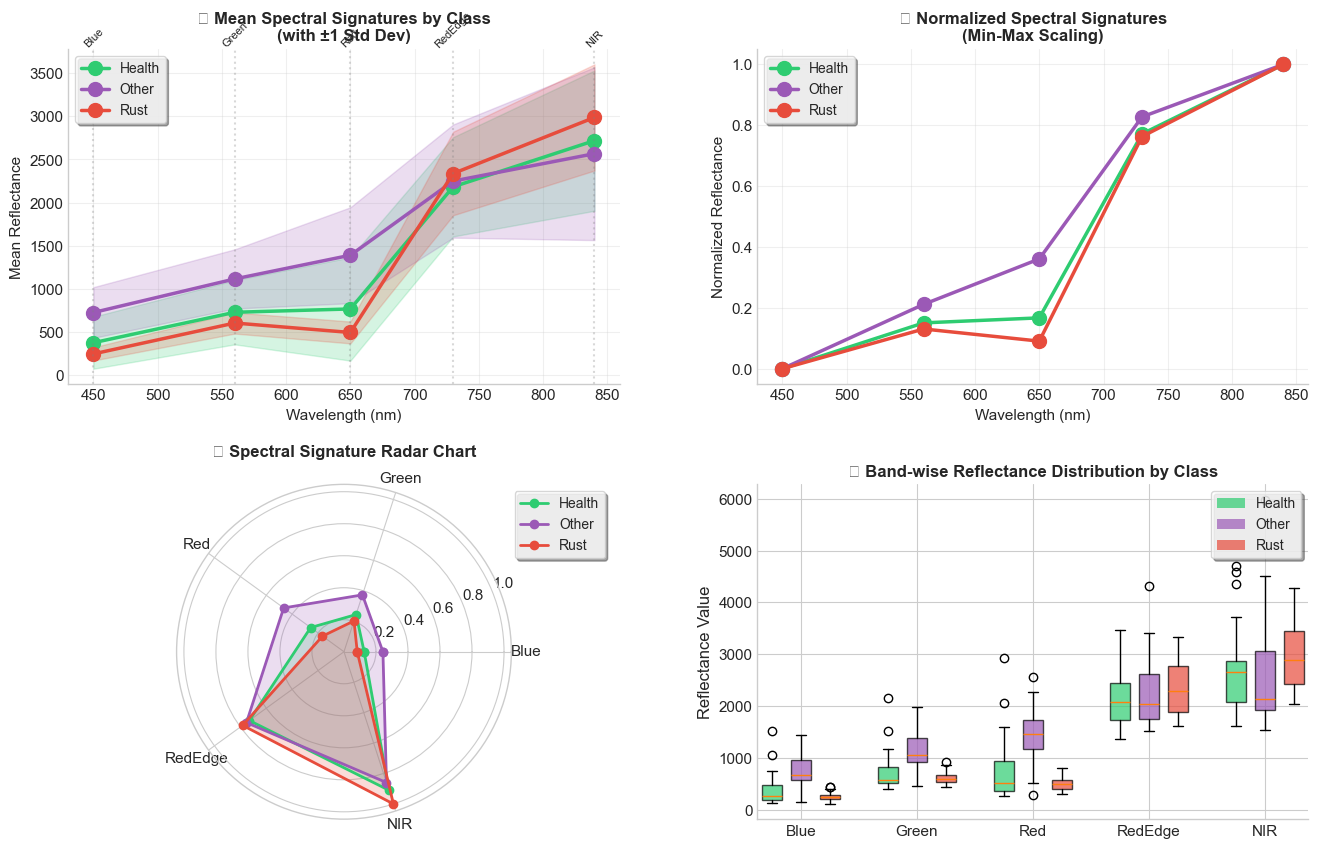

💾 Figure saved: ms_spectral_signatures.png

📡 SPECTRAL SIGNATURE INSIGHTS

Health:
  • Highest reflectance: NIR (2718.30)
  • Lowest reflectance: Blue (377.22)
  • NIR/Red ratio: 3.538 (vegetation indicator)

Other:
  • Highest reflectance: NIR (2567.18)
  • Lowest reflectance: Blue (726.99)
  • NIR/Red ratio: 1.846 (vegetation indicator)

Rust:
  • Highest reflectance: NIR (2986.98)
  • Lowest reflectance: Blue (247.62)
  • NIR/Red ratio: 6.025 (vegetation indicator)


In [34]:
# ============================================================================
# 📈 SECTION 11: SPECTRAL SIGNATURES BY CLASS
# ============================================================================

def analyze_spectral_signatures(df, num_samples=50):
    """
    Phân tích spectral signature cho mỗi class.
    """
    classes = df['Class'].unique()
    wavelengths = [450, 560, 650, 730, 840]  # nm
    
    signatures = {cls: {band: [] for band in range(5)} for cls in classes}
    
    samples = df.groupby('Class', group_keys=False).apply(
        lambda x: x.sample(min(len(x), num_samples // len(classes)), random_state=42)
    ).reset_index(drop=True)
    
    print(f"📡 Analyzing spectral signatures from {len(samples)} samples...")
    
    for _, row in tqdm(samples.iterrows(), total=len(samples), desc="Extracting signatures", ncols=80):
        try:
            img = tiff.imread(row['Path']).astype(np.float32)
            
            if img.ndim == 3 and img.shape[0] > img.shape[2]:
                img = np.transpose(img, (2, 0, 1))
            
            for band in range(min(img.shape[0], 5)):
                mean_val = np.mean(img[band])
                signatures[row['Class']][band].append(mean_val)
                
        except Exception as e:
            continue
    
    return signatures, wavelengths

signatures, wavelengths = analyze_spectral_signatures(df_ms, num_samples=90)

# Visualization
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, hspace=0.3, wspace=0.25)

band_names_short = ['Blue', 'Green', 'Red', 'RedEdge', 'NIR']
class_order = [cls for cls in ['Health', 'Other', 'Rust'] if cls in signatures]

# --- Chart 1: Mean Spectral Signature ---
ax1 = fig.add_subplot(gs[0, 0])

for cls in class_order:
    if cls in signatures:
        means = [np.mean(signatures[cls][b]) for b in range(5)]
        stds = [np.std(signatures[cls][b]) for b in range(5)]
        
        ax1.plot(wavelengths, means, 'o-', linewidth=2.5, markersize=10, 
                 label=cls, color=COLORS.get(cls, '#999999'))
        ax1.fill_between(wavelengths, 
                        np.array(means) - np.array(stds), 
                        np.array(means) + np.array(stds), 
                        alpha=0.2, color=COLORS.get(cls, '#999999'))

ax1.set_xlabel('Wavelength (nm)', fontsize=11)
ax1.set_ylabel('Mean Reflectance', fontsize=11)
ax1.set_title('📡 Mean Spectral Signatures by Class\n(with ±1 Std Dev)', fontweight='bold', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Add band annotations
for i, (wl, bn) in enumerate(zip(wavelengths, band_names_short)):
    ax1.axvline(wl, color='gray', linestyle=':', alpha=0.3)
    ax1.text(wl, ax1.get_ylim()[1], bn, ha='center', va='bottom', fontsize=8, rotation=45)

# --- Chart 2: Normalized Spectral Signature ---
ax2 = fig.add_subplot(gs[0, 1])

for cls in class_order:
    if cls in signatures:
        means = np.array([np.mean(signatures[cls][b]) for b in range(5)])
        # Normalize to 0-1 range
        means_norm = (means - means.min()) / (means.max() - means.min() + 1e-8)
        
        ax2.plot(wavelengths, means_norm, 'o-', linewidth=2.5, markersize=10, 
                 label=cls, color=COLORS.get(cls, '#999999'))

ax2.set_xlabel('Wavelength (nm)', fontsize=11)
ax2.set_ylabel('Normalized Reflectance', fontsize=11)
ax2.set_title('📊 Normalized Spectral Signatures\n(Min-Max Scaling)', fontweight='bold', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# --- Chart 3: Radar/Spider Chart ---
ax3 = fig.add_subplot(gs[1, 0], projection='polar')

angles = np.linspace(0, 2 * np.pi, 5, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

for cls in class_order:
    if cls in signatures:
        means = [np.mean(signatures[cls][b]) for b in range(5)]
        # Normalize for radar chart
        max_val = max(max([np.mean(signatures[c][b]) for b in range(5)]) for c in class_order if c in signatures)
        means_norm = [m / max_val for m in means]
        means_norm += means_norm[:1]
        
        ax3.plot(angles, means_norm, 'o-', linewidth=2, label=cls, color=COLORS.get(cls, '#999999'))
        ax3.fill(angles, means_norm, alpha=0.2, color=COLORS.get(cls, '#999999'))

ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(band_names_short)
ax3.set_title('🎯 Spectral Signature Radar Chart', fontweight='bold', fontsize=12, pad=20)
ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

# --- Chart 4: Band-wise Box Plot ---
ax4 = fig.add_subplot(gs[1, 1])

positions = []
data = []
colors_box = []
labels = []

for i, band in enumerate(range(5)):
    for j, cls in enumerate(class_order):
        if cls in signatures and len(signatures[cls][band]) > 0:
            pos = i * 4 + j
            positions.append(pos)
            data.append(signatures[cls][band])
            colors_box.append(COLORS.get(cls, '#999999'))
            labels.append(f"{band_names_short[i]}")

bp = ax4.boxplot(data, positions=positions, patch_artist=True, widths=0.7)

for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Set x-axis labels
ax4.set_xticks([i * 4 + 1 for i in range(5)])
ax4.set_xticklabels(band_names_short)
ax4.set_ylabel('Reflectance Value')
ax4.set_title('📦 Band-wise Reflectance Distribution by Class', fontweight='bold', fontsize=12)

# Legend
legend_elements = [Patch(facecolor=COLORS.get(cls, '#999999'), label=cls, alpha=0.7) for cls in class_order]
ax4.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('ms_spectral_signatures.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("💾 Figure saved: ms_spectral_signatures.png")

# Print insights
print("\n" + "=" * 70)
print("📡 SPECTRAL SIGNATURE INSIGHTS")
print("=" * 70)

for cls in class_order:
    if cls in signatures:
        means = [np.mean(signatures[cls][b]) for b in range(5)]
        max_band = band_names_short[np.argmax(means)]
        min_band = band_names_short[np.argmin(means)]
        print(f"\n{cls}:")
        print(f"  • Highest reflectance: {max_band} ({max(means):.2f})")
        print(f"  • Lowest reflectance: {min_band} ({min(means):.2f})")
        print(f"  • NIR/Red ratio: {means[4]/means[2]:.3f} (vegetation indicator)")

---
## 📝 Section 12: Summary & Export Report

> Tổng kết kết quả EDA và xuất báo cáo cuối cùng.

💾 Metadata exported to: ms_metadata_report.csv


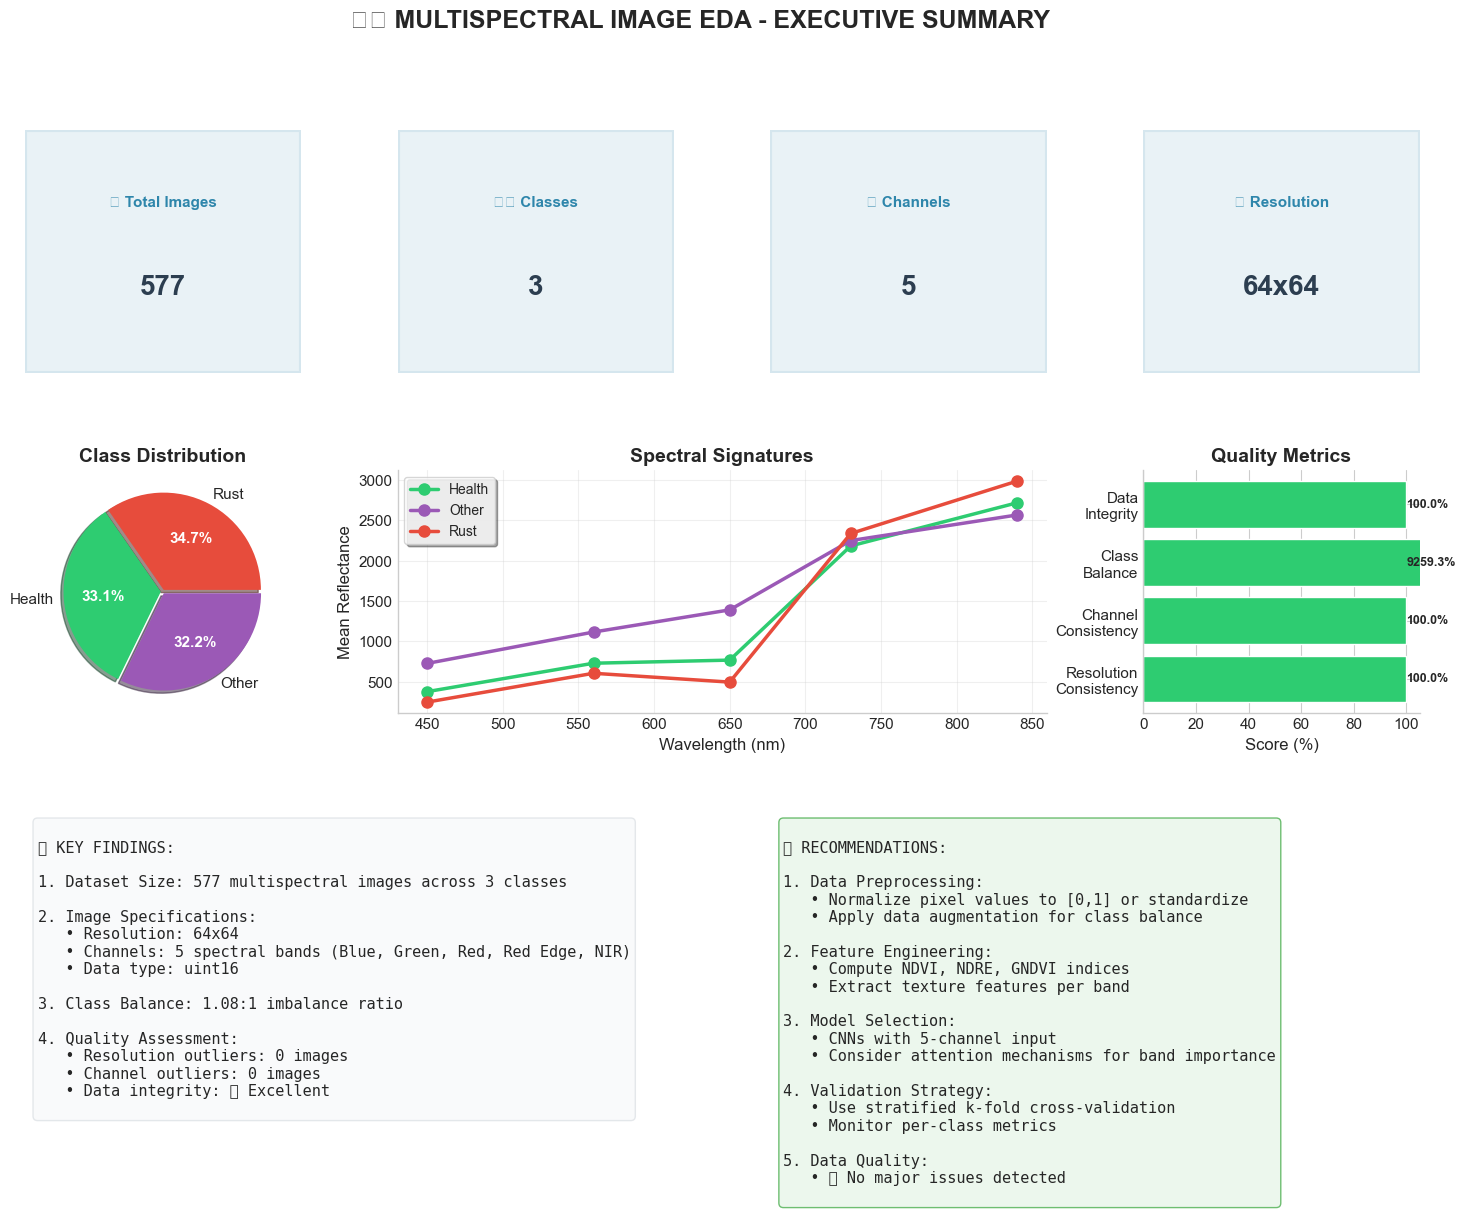


✅ EDA COMPLETED SUCCESSFULLY!

📁 Generated Files:
   • ms_metadata_report.csv
   • ms_class_distribution.png
   • ms_dimensions_analysis.png
   • ms_pixel_statistics.png
   • ms_correlation_analysis.png
   • ms_sample_visualization.png
   • ms_vegetation_indices.png
   • ms_quality_report.png
   • ms_spectral_signatures.png
   • ms_eda_summary.png


In [35]:
# ============================================================================
# 📝 SECTION 12: SUMMARY & EXPORT REPORT
# ============================================================================

# Export metadata to CSV
df_ms.to_csv('ms_metadata_report.csv', index=False)
print("💾 Metadata exported to: ms_metadata_report.csv")

# Create Final Summary Dashboard
fig = plt.figure(figsize=(18, 12))
fig.suptitle('🛰️ MULTISPECTRAL IMAGE EDA - EXECUTIVE SUMMARY', 
             fontsize=18, fontweight='bold', y=0.98)

gs = GridSpec(3, 4, hspace=0.4, wspace=0.35)

# --- Metric Cards ---
metrics = [
    ('📊 Total Images', f"{len(df_ms):,}"),
    ('🏷️ Classes', f"{df_ms['Class'].nunique()}"),
    ('🔬 Channels', f"{df_ms['Channels'].mode().iloc[0] if not df_ms.empty else 'N/A'}"),
    ('📐 Resolution', f"{df_ms['Resolution'].mode().iloc[0] if not df_ms.empty else 'N/A'}")
]

for i, (title, value) in enumerate(metrics):
    ax = fig.add_subplot(gs[0, i])
    ax.axis('off')
    
    # Card background
    ax.add_patch(plt.Rectangle((0, 0), 1, 1, transform=ax.transAxes, 
                                facecolor=COLORS['primary'], alpha=0.1, 
                                edgecolor=COLORS['primary'], linewidth=3))
    
    ax.text(0.5, 0.7, title, transform=ax.transAxes, ha='center', va='center',
            fontsize=11, fontweight='bold', color=COLORS['primary'])
    ax.text(0.5, 0.35, value, transform=ax.transAxes, ha='center', va='center',
            fontsize=20, fontweight='bold', color='#2c3e50')

# --- Class Distribution Pie ---
ax_pie = fig.add_subplot(gs[1, 0])
class_counts = df_ms['Class'].value_counts()
pie_colors = [COLORS.get(c, '#999999') for c in class_counts.index]
wedges, texts, autotexts = ax_pie.pie(
    class_counts.values, 
    labels=class_counts.index,
    autopct='%1.1f%%',
    colors=pie_colors,
    explode=[0.02] * len(class_counts),
    shadow=True
)
ax_pie.set_title('Class Distribution', fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# --- Spectral Signature Summary ---
ax_spec = fig.add_subplot(gs[1, 1:3])
for cls in class_order:
    if cls in signatures:
        means = [np.mean(signatures[cls][b]) for b in range(5)]
        ax_spec.plot(wavelengths, means, 'o-', linewidth=2.5, markersize=8, 
                     label=cls, color=COLORS.get(cls, '#999999'))

ax_spec.set_xlabel('Wavelength (nm)')
ax_spec.set_ylabel('Mean Reflectance')
ax_spec.set_title('Spectral Signatures', fontweight='bold')
ax_spec.legend()
ax_spec.grid(True, alpha=0.3)

# --- Quality Status ---
ax_qual = fig.add_subplot(gs[1, 3])
quality_metrics = ['Resolution\nConsistency', 'Channel\nConsistency', 'Class\nBalance', 'Data\nIntegrity']
quality_values = [
    100 - (report['Resolution Outliers'] / len(df_ms) * 100),
    100 - (report['Channel Outliers'] / len(df_ms) * 100),
    100 / float(report['Class Imbalance Ratio'].split(':')[0]) * 100 if ':' in report['Class Imbalance Ratio'] else 100,
    100 - (report['Missing Values'] / len(df_ms) * 100)
]

colors_qual = ['#2ECC71' if v >= 90 else '#F39C12' if v >= 70 else '#E74C3C' for v in quality_values]
bars = ax_qual.barh(quality_metrics, quality_values, color=colors_qual, edgecolor='white')
ax_qual.set_xlim(0, 105)
ax_qual.set_xlabel('Score (%)')
ax_qual.set_title('Quality Metrics', fontweight='bold')

for bar, val in zip(bars, quality_values):
    ax_qual.text(min(val + 2, 100), bar.get_y() + bar.get_height()/2, 
                 f'{val:.1f}%', va='center', fontweight='bold', fontsize=9)

# --- Key Findings Text Box ---
ax_text = fig.add_subplot(gs[2, :2])
ax_text.axis('off')

findings = f"""
📋 KEY FINDINGS:

1. Dataset Size: {len(df_ms):,} multispectral images across {df_ms['Class'].nunique()} classes
   
2. Image Specifications:
   • Resolution: {df_ms['Resolution'].mode().iloc[0] if not df_ms.empty else 'N/A'}
   • Channels: {df_ms['Channels'].mode().iloc[0] if not df_ms.empty else 'N/A'} spectral bands (Blue, Green, Red, Red Edge, NIR)
   • Data type: {df_ms['Dtype'].mode().iloc[0] if not df_ms.empty else 'N/A'}
   
3. Class Balance: {report['Class Imbalance Ratio']} imbalance ratio

4. Quality Assessment:
   • Resolution outliers: {report['Resolution Outliers']} images
   • Channel outliers: {report['Channel Outliers']} images
   • Data integrity: {'✅ Excellent' if report['Missing Values'] == 0 else '⚠️ Issues detected'}
"""

ax_text.text(0.02, 0.95, findings, transform=ax_text.transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='#f8f9fa', edgecolor='#dee2e6', alpha=0.8))

# --- Recommendations ---
ax_rec = fig.add_subplot(gs[2, 2:])
ax_rec.axis('off')

recommendations = f"""
💡 RECOMMENDATIONS:

1. Data Preprocessing:
   • Normalize pixel values to [0,1] or standardize
   • Apply data augmentation for class balance
   
2. Feature Engineering:
   • Compute NDVI, NDRE, GNDVI indices
   • Extract texture features per band
   
3. Model Selection:
   • CNNs with 5-channel input
   • Consider attention mechanisms for band importance
   
4. Validation Strategy:
   • Use stratified k-fold cross-validation
   • Monitor per-class metrics
   
5. Data Quality:
   • {'✅ No major issues detected' if report['Resolution Outliers'] + report['Channel Outliers'] == 0 else '⚠️ Review flagged anomalies before training'}
"""

ax_rec.text(0.02, 0.95, recommendations, transform=ax_rec.transAxes, 
            fontsize=11, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='#e8f5e9', edgecolor='#4caf50', alpha=0.8))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('ms_eda_summary.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\n" + "=" * 70)
print("✅ EDA COMPLETED SUCCESSFULLY!")
print("=" * 70)
print("\n📁 Generated Files:")
print("   • ms_metadata_report.csv")
print("   • ms_class_distribution.png")
print("   • ms_dimensions_analysis.png")
print("   • ms_pixel_statistics.png")
print("   • ms_correlation_analysis.png")
print("   • ms_sample_visualization.png")
print("   • ms_vegetation_indices.png")
print("   • ms_quality_report.png")
print("   • ms_spectral_signatures.png")
print("   • ms_eda_summary.png")